In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.stats import binned_statistic_2d

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [3]:
snapdics = {}
regs = 'WAf'
for ids, y in enumerate(range(2000,2021)):
    #'ipdb.set_trace()
    try:
        test = pd.read_csv(glob.glob('/media/ck/LStorage/global_water/MCS_5000km2_tables/ERA5_added/'+regs+'/'+str(y)+'*.csv')[0])
    except:
        ipdb.set_trace()
#      
    if ids == 0:
        test2 = pd.DataFrame(test)
    else :
        test2 = pd.concat([test2, test])
            
obs_gpmf = test2

In [4]:
obs_gpmf.head()

tcwv   tgrad2m  tgrad925  tgrad850        smgrad    efgrad     shgrad  \
0  60.580162  0.503964  0.442407  0.458709  1.340865e-01 -0.020639  15.829279   
1  62.314865 -0.321032  0.275752  0.239324  1.795802e-01 -0.013562  10.442458   
2  41.495834  0.086910  0.199784  0.038642 -1.349284e-02  0.001636   0.606288   
3  58.127754 -0.267128  0.122050  0.272299  1.470162e-22 -0.023062   0.753768   
4  52.903130  2.010908  0.248524 -0.037631 -5.330400e-02 -0.096103  19.231504   

      lhgrad      q925      q650  ...        tp1       tp99  \
0  48.979835  0.015830  0.006661  ... -78.390755 -50.195659   
1  42.032359  0.015738  0.007825  ... -73.989543 -50.212728   
2   4.745912  0.015687  0.005289  ... -73.253220 -50.605441   
3 -19.071948  0.014244  0.006643  ... -65.798817 -50.286090   
4 -19.577698  0.016384  0.006391  ... -76.035875 -50.944692   

               stormID  precipitation_mean  precipitation_max  \
0   2000-06-01_15:30_1            3.692413          59.812855   
1   2000-06-01_15:30_3            3.367093          17.841707   
2   2000-06-01_15:30_8            0.898647           6.087396   
3  2000-06-01_15:30_10            9.562878          36.920570   
4  2000-06-01_15:30_35            5.408433          12.024405   

   precipitation_p95  precipitation_p99  lt_hour          lt_datetime  \
0          15.135321          28.921845       15  2000-06-01 15:00:00   
1          13.629379          17.684397       15  2000-06-01 15:00:00   
2           2.678089           5.991026       15  2000-06-01 15:00:00   
3          31.177693          36.114065       15  2000-06-01 15:00:00   
4          10.292399          11.377469       15  2000-06-01 15:00:00   

     utc_date  
0  2000-06-01  
1  2000-06-01  
2  2000-06-01  
3  2000-06-01  
4  2000-06-01  

[5 rows x 74 columns]

In [5]:
#obs_gpmf.to_csv('/home/ck/DIR/cornkle/data/LMCS/CLOVER_mcs_tables/obs_bulk_-50_5000km2_GPM_passiveMW_5-18N_17W13E_ERA0.7_15kprecip_hourly.csv')

In [6]:
histf = pd.read_csv('/home/ck/DIR/cornkle/data/LMCS/CLOVER_mcs_tables/CP4hist_bulk_-50_5000km2_5-25N_12W15E_15kprecip_hourly.csv')
futf = pd.read_csv('/home/ck/DIR/cornkle/data/LMCS/CLOVER_mcs_tables/CP4fut_bulk_-50_5000km2_5-25N_12W15E_15kprecip_hourly.csv')

In [7]:
np.percentile(histf['tcwv'],0.5)  # 99.5 percentile

25.460361663990856

25099.39145010042
26751.74994684244
28461.402164958883
29766.406519895732
30928.207245511087


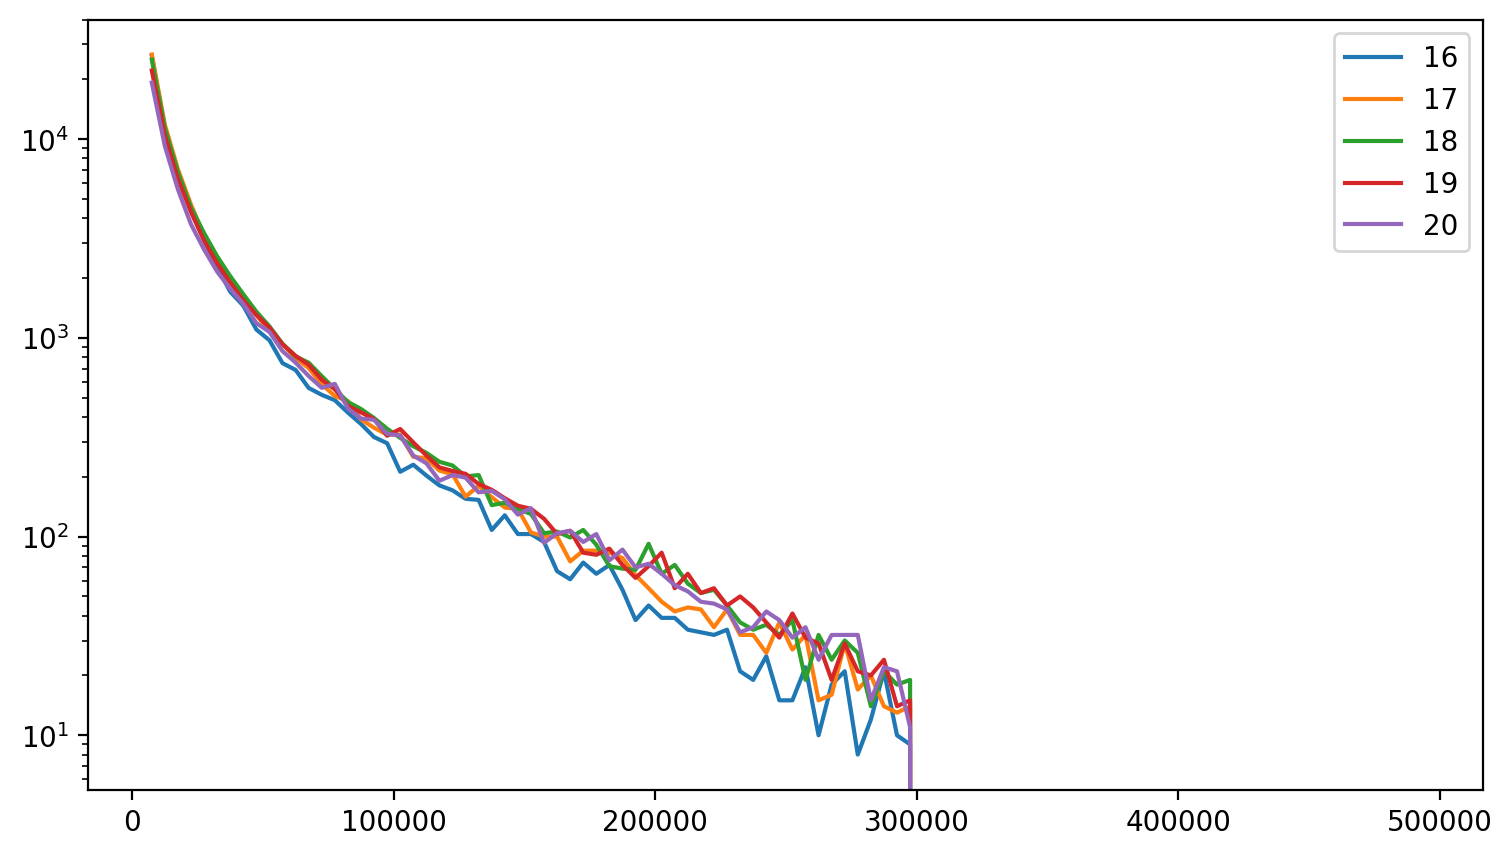

In [8]:
from utils import u_statistics as u_stats
f = plt.figure(figsize=(9,5), dpi=200)
ax = f.add_subplot(111)
for h in ([16, 17,18,19,20]):
    hist, count, binz = u_stats.histo_frequency(obs_gpmf[obs_gpmf['hour']==h]['area'], bins=np.arange(5000,500000,5000))
    #ax.hist(obs_gpmf[obs_gpmf['hour']==h]['area'], bins=np.arange(5000,500000,5000), label=str(h))
    binmid = binz[1::]-(binz[1::]-binz[0:-1])/2
   # ipdb.set_trace()
    plt.plot(binmid, count, label=str(h))
    ax.set_yscale('log')
    print(np.mean(obs_gpmf[obs_gpmf['hour']==h]['area']))
    
plt.legend()

In [9]:
print(np.max(obs_gpmf.clat))
print(np.min(obs_gpmf.clat))
print(np.max(obs_gpmf.clon))
print(np.min(obs_gpmf.clon))

24.850000381469727
4.150000095367432
24.800000190734863
-17.850000381469727


In [10]:
print(np.max(histf.lat))
print(np.min(histf.lat))
print(np.max(histf.lon))
print(np.min(histf.lon))

24.762752532958984
5.181001663208008
14.764739990234377
-11.783004760742188


In [11]:
ttag='hourly'
tag = 'Sahel'
domainSA = [-10,12,5,8.5]
domainSS = [-10,12,11,18]#[-10,15,9,18]  # 8.5, 17.5
domainWA = [-10,12,5,17.5]
domainOuaga = [-4.5,2,11,13.5]  

nb = 23
if ttag == 'hourly':
    region = {'Sahel' : [domainSS, 'SoudanoSahel', np.linspace(9.5,17.8,nb) , np.linspace(3,24,nb), np.linspace(-10,10,nb), np.linspace(29,55,nb)], #TCW np.linspace(25,57,nb) #np.linspace(10,17.5,17) , np.linspace(0,25,17)  # monthly tcwv 30-50
              'Ouaga' : [domainOuaga, 'Ouaga', np.linspace(9.5,17.8,nb) , np.linspace(0,27,nb), np.linspace(-10,10,nb), np.linspace(25,57,nb)],
              'WA' : [domainWA, 'fullWA', np.linspace(11.5,19.5,nb), np.linspace(3,27,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
              'SWA' : [domainSA, 'southernWA', np.linspace(12.8,17.5,nb), np.linspace(0,25,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
             }
else:
    region = {'Sahel' : [domainSS, 'SoudanoSahel', np.linspace(9.5,17.8,nb) , np.linspace(7,18,nb), np.linspace(-10,10,nb), np.linspace(28,51,nb)], # 28,51 #np.linspace(10,17.5,17) , np.linspace(0,25,17)  # monthly tcwv 30-50
          'Ouaga' : [domainOuaga, 'Ouaga', np.linspace(9.5,17.8,nb) , np.linspace(0,27,nb), np.linspace(-10,10,nb), np.linspace(25,57,nb)],
          'WA' : [domainWA, 'fullWA', np.linspace(11.5,19.5,nb), np.linspace(3,27,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
          'SWA' : [domainSA, 'southernWA', np.linspace(12.8,17.5,nb), np.linspace(0,25,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
         }


domain = region[tag][0]
tname = region[tag][1]


m1 = 5#3
m2 =10#11
obs_gpm = obs_gpmf[(obs_gpmf.clon>=domain[0])&(obs_gpmf.clon<=domain[1])&(obs_gpmf.clat>=domain[2])&(obs_gpmf.clat<=domain[3])& (obs_gpmf.month>=m1) & (obs_gpmf.month<=m2)] #& (obs_gpm.month!=6) & (obs_gpm.month!=9)]
hist = histf[(histf.lon>=domain[0])&(histf.lon<=domain[1])&(histf.lat>=domain[2])&(histf.lat<=domain[3])& (histf.month>=m1) & (histf.month<=m2)]# & (histf.tbox<=10)]
fut = futf[(futf.lon>=domain[0])&(futf.lon<=domain[1])&(futf.lat>=domain[2])&(futf.lat<=domain[3])& (futf.month>=m1) & (futf.month<=m2)]# & (futf.tbox<=10)]


In [12]:
print('hist', hist.lat.min(), hist.lat.max(), hist.lon.min(), hist.lon.max())
print('OBS_gpm', obs_gpm.clat.min(), obs_gpm.clat.max(), obs_gpm.clon.min(), obs_gpm.clon.max())

hist 11.013002395629885 17.99925422668457 -9.980758666992188 11.990509033203123
OBS_gpm 11.0 18.0 -10.0 12.0


In [13]:
len(obs_gpm)

54730

In [14]:
np.mean(hist.prcp)


19.686368254174287

In [15]:
np.percentile(hist.prcp,95)

40.66572374704551

In [16]:
hist.prcp

2066      18.438323
2069      21.878401
2080      23.399325
2090      16.411038
2108      21.865938
            ...    
128947    24.013017
128960    14.033019
128970     4.135596
128986    10.298958
129062     7.672075
Name: prcp, Length: 35581, dtype: float64

Text(0.5, 1.0, '-0.59')

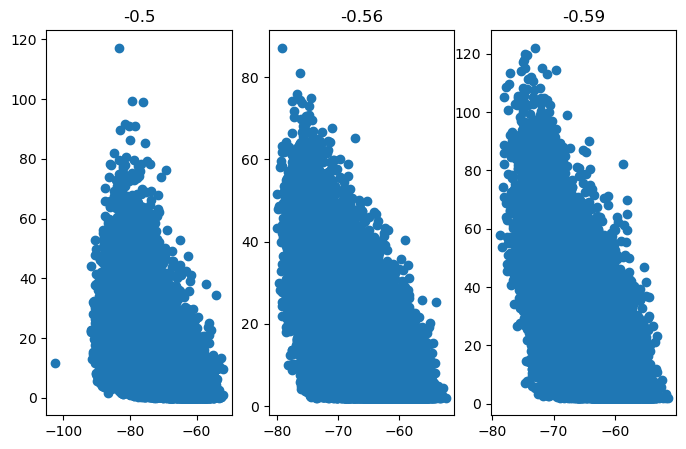

In [17]:

cp4s = [obs_gpm.tmin, obs_gpm.precipitation_max] # gpm
cp25s = [hist.tmin, hist.prcp] #cp4
futur = [fut.tmin, fut.prcp] 


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))





Text(0.5, 1.0, '-0.54')

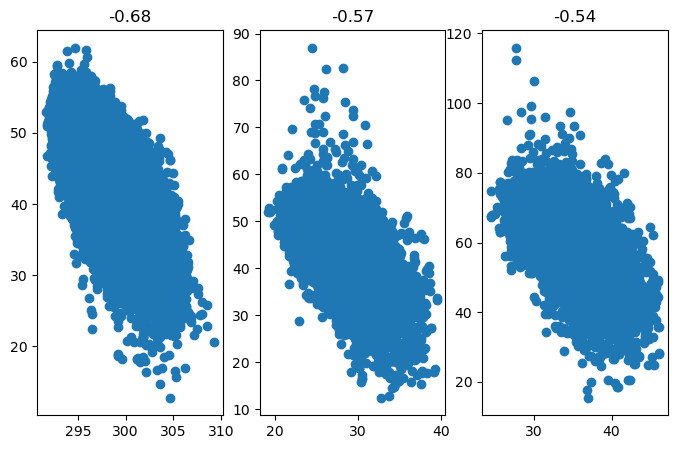

In [18]:

cp4s = [obs_gpm.t925, obs_gpm.tcwv] # gpm
cp25s = [hist.t925, hist.tcwv] #cp4
futur = [fut.t925, fut.tcwv] #cp4


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

Text(0.5, 1.0, '0.04')

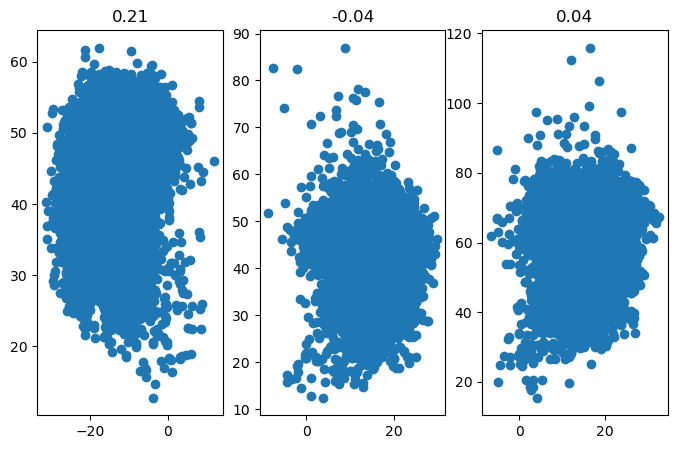

In [19]:

cp4s = [obs_gpm.ushear925_650, obs_gpm.tcwv] # gpm
cp25s = [hist.shear, hist.tcwv] #cp4
futur = [fut.shear, fut.tcwv] #cp4


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

In [20]:
oposi = (obs_gpm.q925*1000>=8.) & ((obs_gpm.ushear925_650*-1)>0) &  (obs_gpm.precipitation_max>=10) & (obs_gpm.area>=5000) & (obs_gpm.tmin<=-55) # & ((obs_gpm.month>=9) | (obs_gpm.month<=5)) #0.1
cposi = (hist.q925>=8.) & (hist.shear>0) &  (hist.prcp>=10) & (np.isfinite(hist.q925)) & np.isfinite(hist.shear)  & (hist.area>=5000) & (hist.tmin<=-55)
fposi = (fut.q925>=8.) & (fut.shear>0) &  (fut.prcp>=10) & (np.isfinite(fut.q925)) & np.isfinite(fut.shear)  & (fut.area>=5000) & (fut.tmin<=-55)

In [21]:
oposi

46       False
59        True
75       False
99        True
105      False
         ...  
21315    False
21321     True
21322    False
21327     True
21331     True
Length: 54730, dtype: bool

In [22]:
obs = obs_gpm[oposi]
cp4 = hist[cposi]
cp4f = fut[fposi]
cp4.area = cp4.area.values

/tmp/ipykernel_11204/1230285955.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cp4.area = cp4.area.values


In [23]:
np.percentile(obs.tcwv,99)

54.25063999176025

In [24]:
cp4.area.min()

5014.240000000001

In [25]:
obs.area.min()

5000

In [26]:
len(obs)

28164

In [27]:
len(cp4)

27091

In [28]:
len(cp4f)

22559

In [29]:
obs['shear'] = obs['ushear925_650']*-1
obs['prcp'] = obs['precipitation_max']

/tmp/ipykernel_11204/1854710102.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['shear'] = obs['ushear925_650']*-1
/tmp/ipykernel_11204/1854710102.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['prcp'] = obs['precipitation_max']


/home/ck/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ck/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ck/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ck/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/ck/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'MCS number')

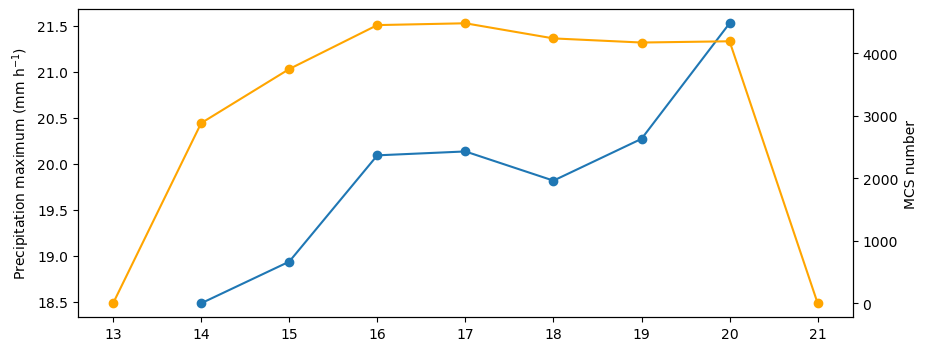

In [30]:
from endgame import hist2d
outdic = hist2d.var2_binning_mean(obs['hour'].values, obs['prcp'].values, np.array([13.5,14.5,15.5,16.5,17.5,18.5,19.5,20.5,21.5,22.5]))
#from scipy.ndimage import gaussian_filter1d
f= plt.figure(figsize=(10,4), dpi=100)
ax = f.add_subplot(111)
ax.plot(outdic['xbins']-1, outdic['y'], marker='o')
ax.set_ylabel('Precipitation maximum (mm h$^{-1}$)')
ax1 = ax.twinx()
ax1.plot(outdic['xbins']-1, outdic['ycount'], marker='o', color='orange')
ax1.set_ylabel('MCS number')

(array([   0., 2883., 3748., 4451., 4480., 4238., 4172.]),
 array([13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5]),
 <BarContainer object of 7 artists>)

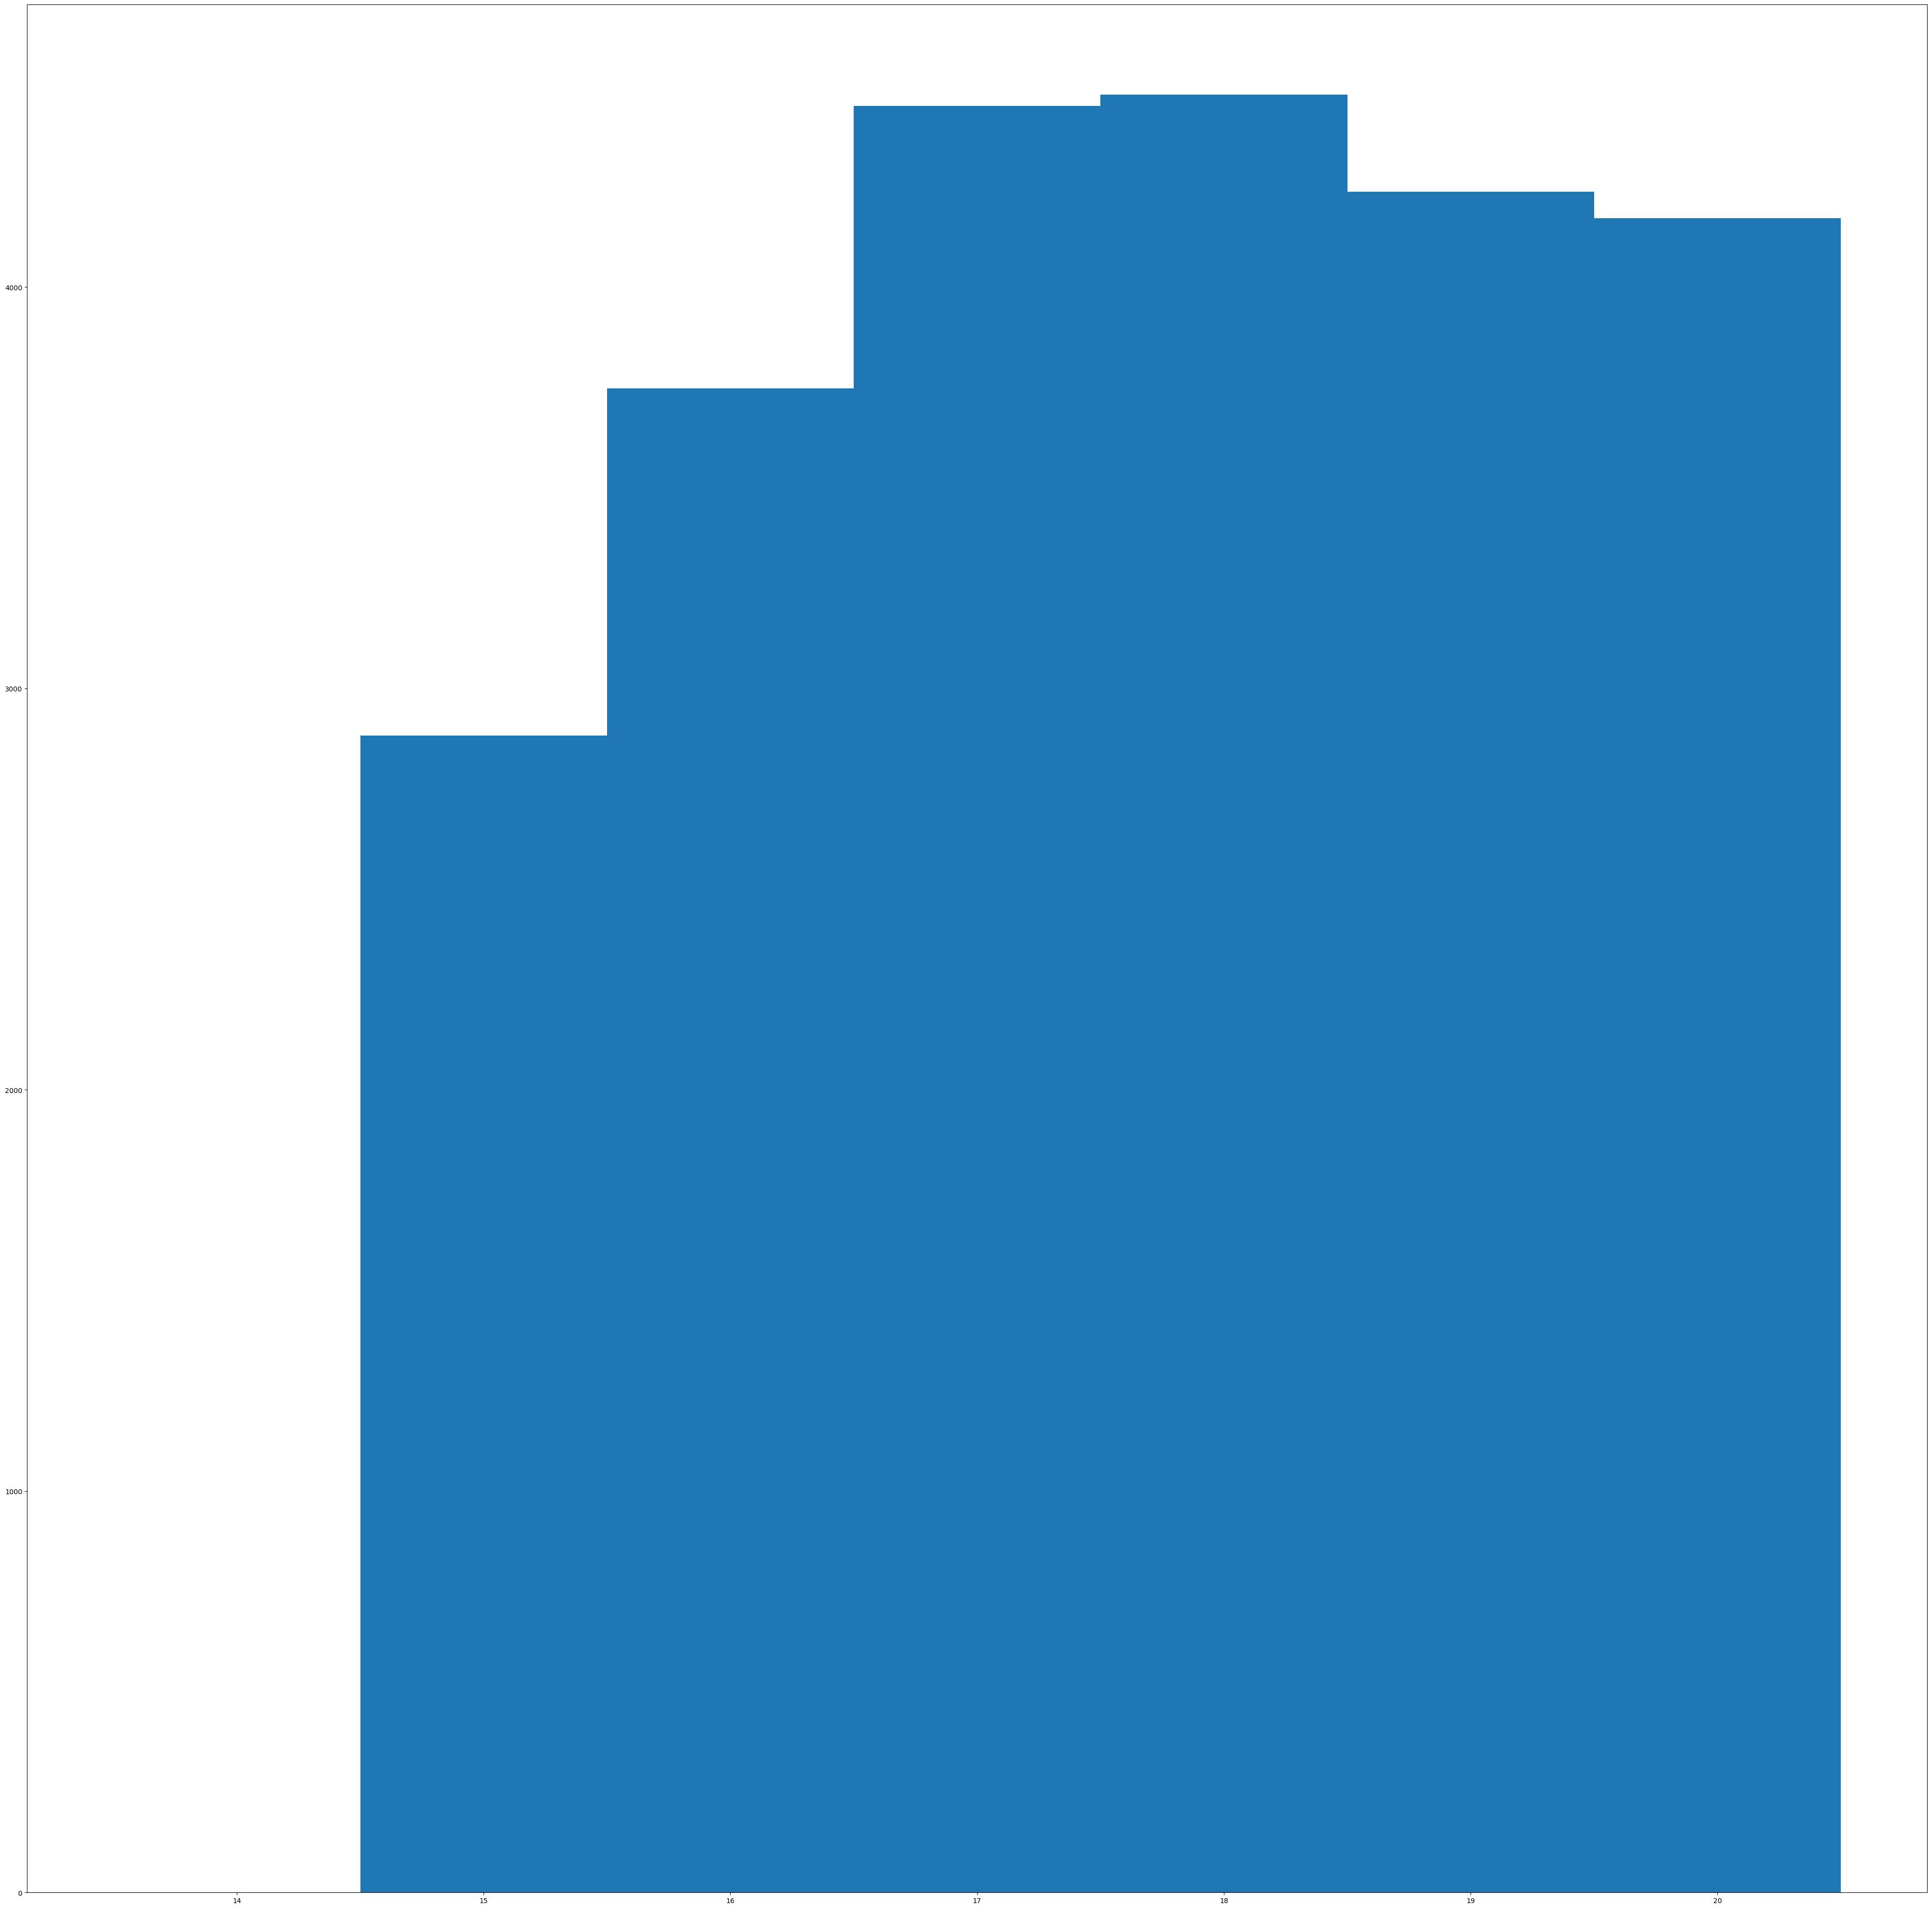

In [31]:
plt.hist(obs['hour'], bins=np.arange(13.5,21.5,1))

In [32]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

PearsonRResult(statistic=-0.25281206642635173, pvalue=0.0)


Text(0.5, 0, 'MCS index')

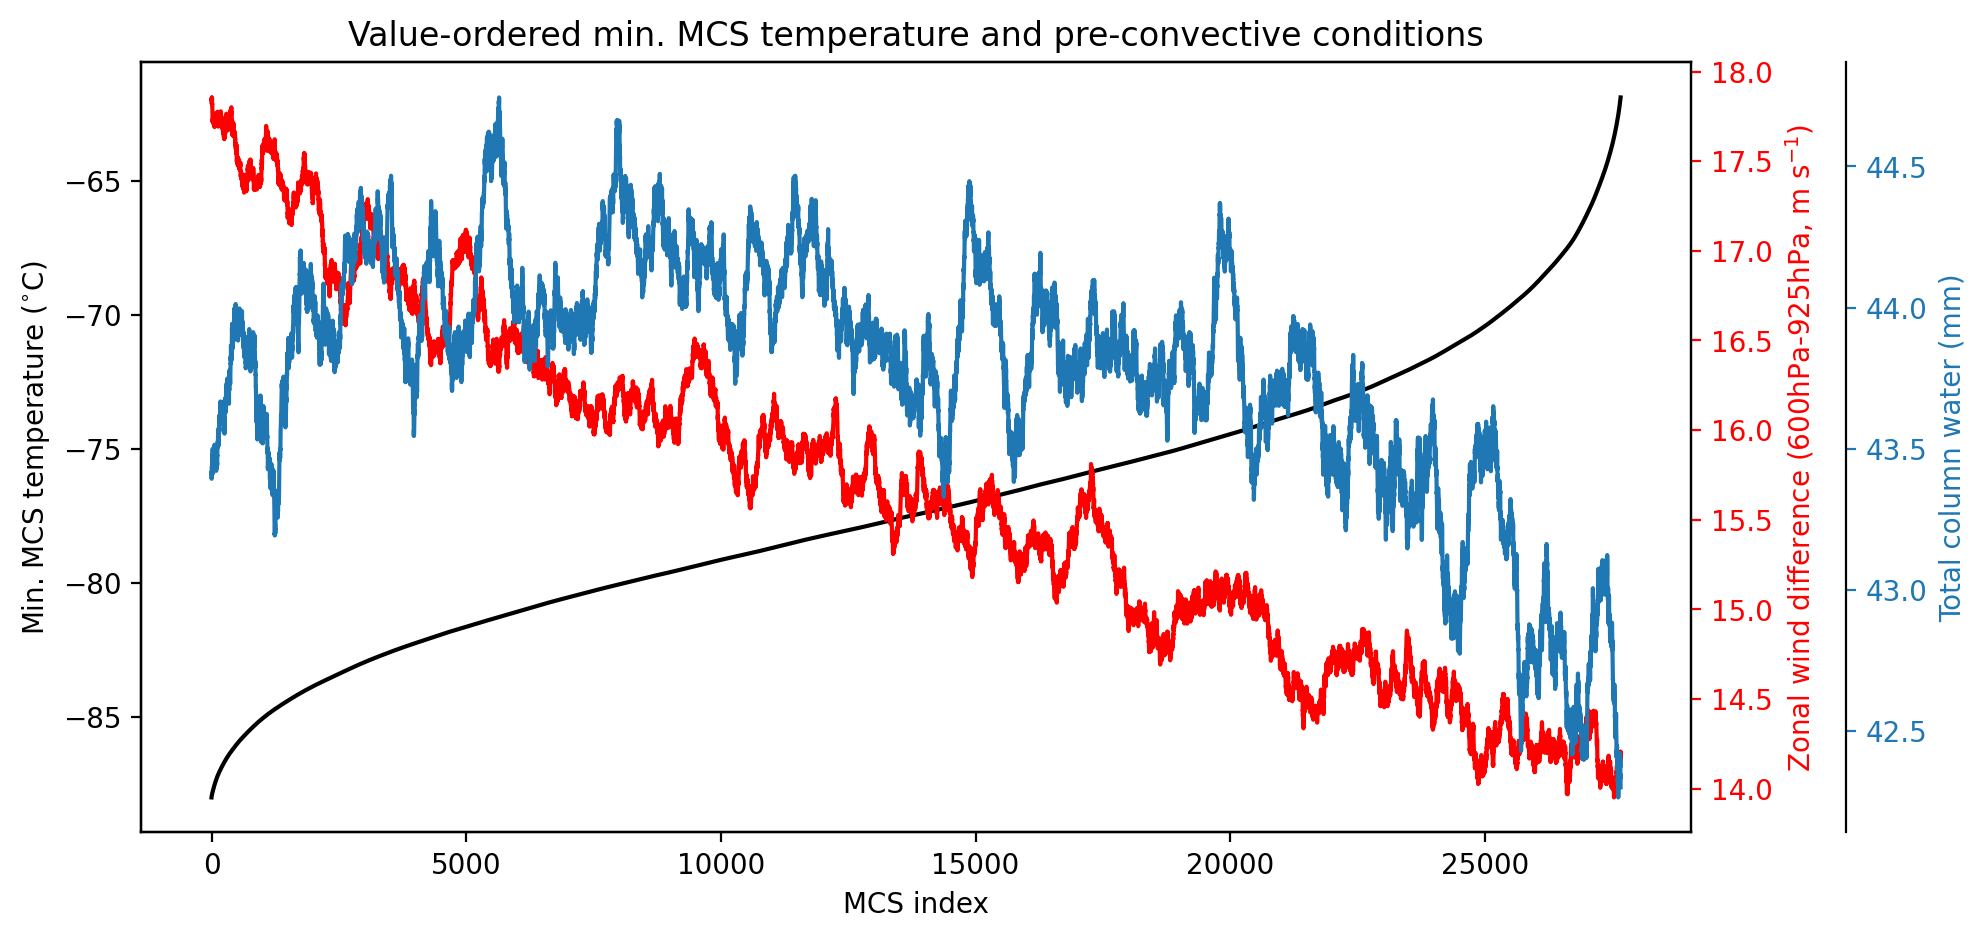

In [65]:
obsord = obs[np.isfinite(obs['prcp']) & np.isfinite(obs['shear']) & np.isfinite(obs['q925']) & np.isfinite(obs['t925'])]
inds = np.argsort(obsord['tmin'])

minus = -20000
pro = obsord['tmin'].values[inds]#[minus::]
sho = obsord['shear'].values[inds]#[minus::]
tco = obsord['tcwv'].values[inds]#[minus::]
qco = obsord['q925'].values[inds]#[minus::]
temp = obsord['t925'].values[inds]#[minus::]
qupco = obsord['q650'].values[inds]#[minus::]

f = plt.figure(figsize=(10,5), dpi=200)
ax = f.add_subplot(111)
ax2 = ax.twinx()
#ax3 = ax.twinx()
ax4 = ax.twinx()

agg = 500


# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
#ax2.spines["right"].set_position(("axes", 1.02))
#ax3.spines["right"].set_position(("axes", 1.1))
ax4.spines["right"].set_position(("axes", 1.1))

ax.plot(moving_average(pro,agg), label='prcp', color='k')

p4, = ax4.plot(moving_average(tco,agg), label='tcw')
p2, = ax2.plot(moving_average(sho,agg), label='shear', color='r')
#p3, = ax3.plot(moving_average(qco,500), label='q925', color='purple')
#p4, = ax4.plot(moving_average(temp,500), label='t925', color='orange')

ax2.yaxis.label.set_color(p2.get_color())
#ax3.yaxis.label.set_color(p3.get_color())
ax4.yaxis.label.set_color(p4.get_color())

tw = moving_average(tco,agg)
twd = tw[1::]-tw[0:-1]
sw = moving_average(sho,agg)
swd = sw[1::]-sw[0:-1]

print(stats.pearsonr(twd,swd))

ax.set_ylabel('Min. MCS temperature ($^{\circ}$C)')
ax2.set_ylabel('Zonal wind difference (600hPa-925hPa, m s$^{-1}$)')
ax4.set_ylabel('Total column water (mm)')


ax2.tick_params(axis='y', colors=p2.get_color())
#ax3.tick_params(axis='y', colors=p3.get_color() )
ax4.tick_params(axis='y', colors=p4.get_color())

ax.set_title('Value-ordered min. MCS temperature and pre-convective conditions')
ax.set_xlabel('MCS index')

#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/ordered_MCSs/minT_ordered_15000.jpg')

PearsonRResult(statistic=-0.2571055098051527, pvalue=0.0)


Text(0.5, 0, 'MCS index')

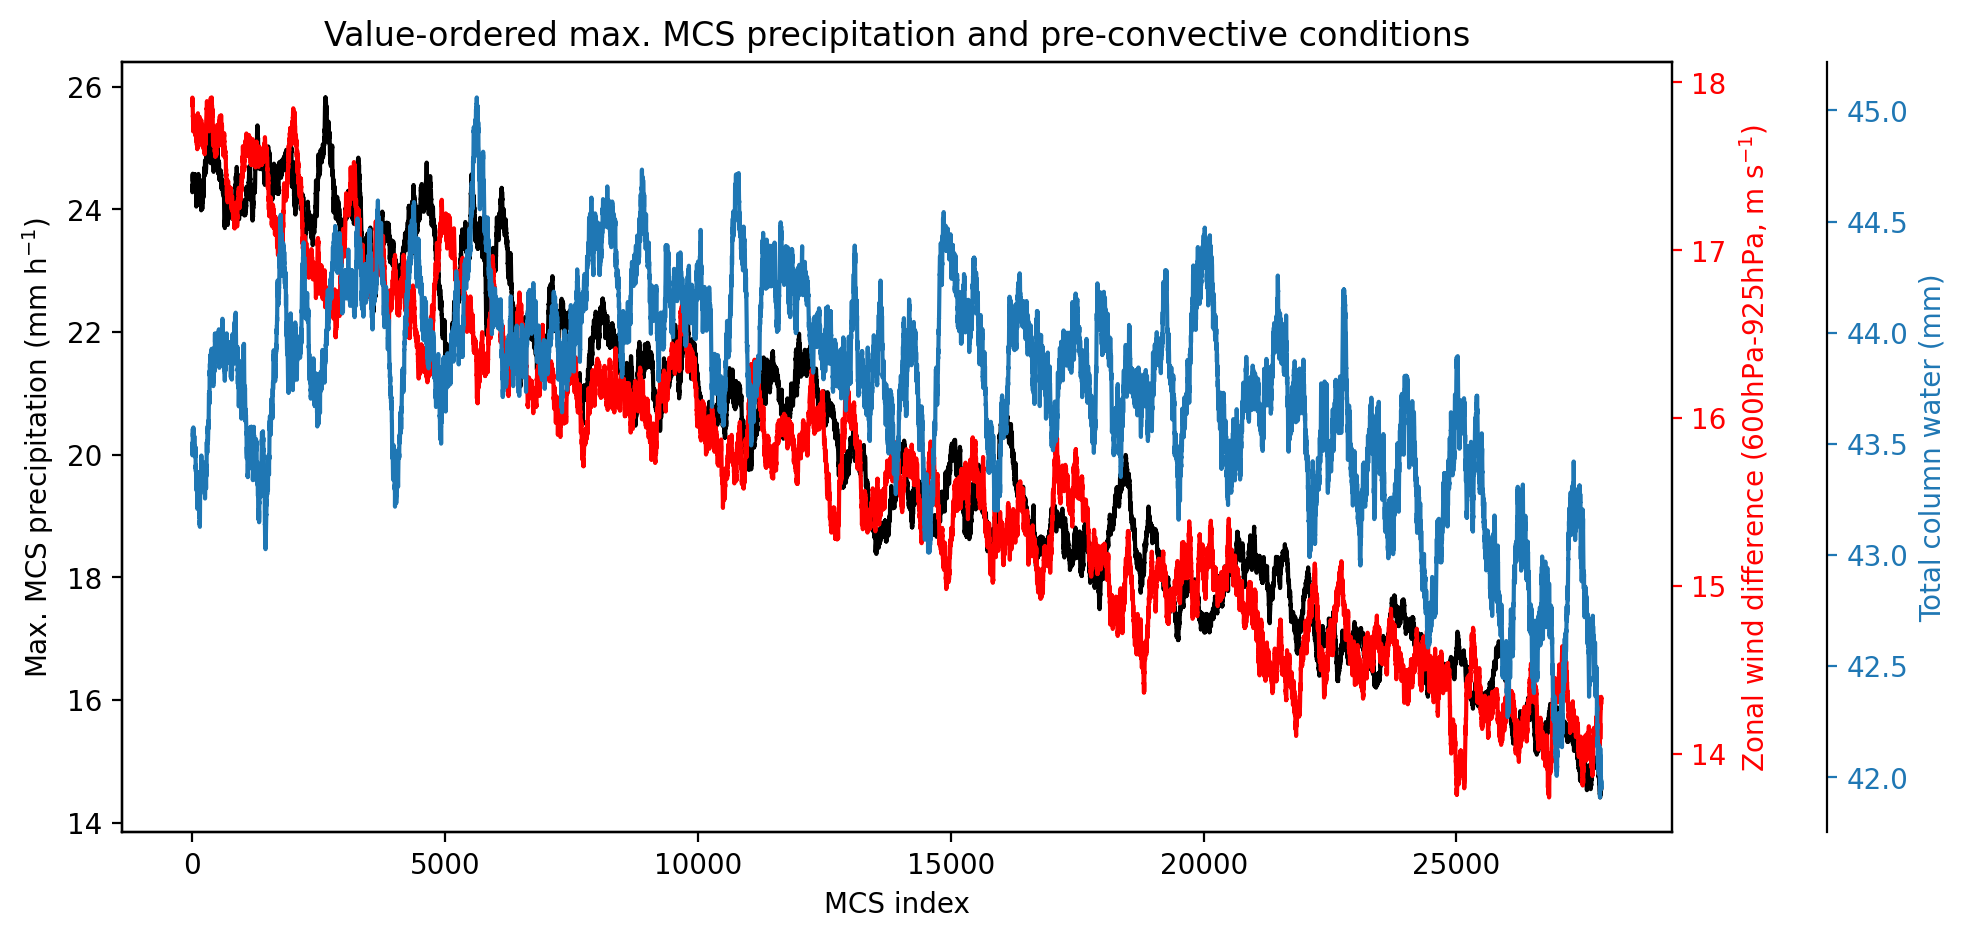

In [66]:
obsord = obs[np.isfinite(obs['prcp']) & np.isfinite(obs['shear']) & np.isfinite(obs['q925']) & np.isfinite(obs['t925'])]
inds = np.argsort(obsord['tmin']) # tmin

minus = -20000
pro = obsord['prcp'].values[inds]#[minus::]
sho = obsord['shear'].values[inds]#[minus::]
tco = obsord['tcwv'].values[inds]#[minus::]
qco = obsord['q925'].values[inds]#[minus::]
temp = obsord['t925'].values[inds]#[minus::]
qupco = obsord['q650'].values[inds]#[minus::]

f = plt.figure(figsize=(10,5), dpi=200)
ax = f.add_subplot(111)
ax2 = ax.twinx()
#ax3 = ax.twinx()
ax4 = ax.twinx()

agg = 300  # 500


# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
#ax2.spines["right"].set_position(("axes", 1.02))
#ax3.spines["right"].set_position(("axes", 1.1))
ax4.spines["right"].set_position(("axes", 1.1))

ax.plot(moving_average(pro,agg), label='prcp', color='k')

p4, = ax4.plot(moving_average(tco,agg), label='tcw')
p2, = ax2.plot(moving_average(sho,agg), label='shear', color='r')
#p3, = ax3.plot(moving_average(qco,500), label='q925', color='purple')
#p4, = ax4.plot(moving_average(temp,500), label='t925', color='orange')

ax2.yaxis.label.set_color(p2.get_color())
#ax3.yaxis.label.set_color(p3.get_color())
ax4.yaxis.label.set_color(p4.get_color())

tw = moving_average(tco,agg)
twd = tw[1::]-tw[0:-1]
sw = moving_average(sho,agg)
swd = sw[1::]-sw[0:-1]

print(stats.pearsonr(twd,swd))

ax.set_ylabel('Max. MCS precipitation (mm h$^{-1}$)')
ax2.set_ylabel('Zonal wind difference (600hPa-925hPa, m s$^{-1}$)')
ax4.set_ylabel('Total column water (mm)')


ax2.tick_params(axis='y', colors=p2.get_color())
#ax3.tick_params(axis='y', colors=p3.get_color() )
ax4.tick_params(axis='y', colors=p4.get_color())

ax.set_title('Value-ordered max. MCS precipitation and pre-convective conditions')
ax.set_xlabel('MCS index')

#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/ordered_MCSs/minT_ordered_withP_15000.jpg')

(-0.20842950913302125, 4.268141716835625e-165)


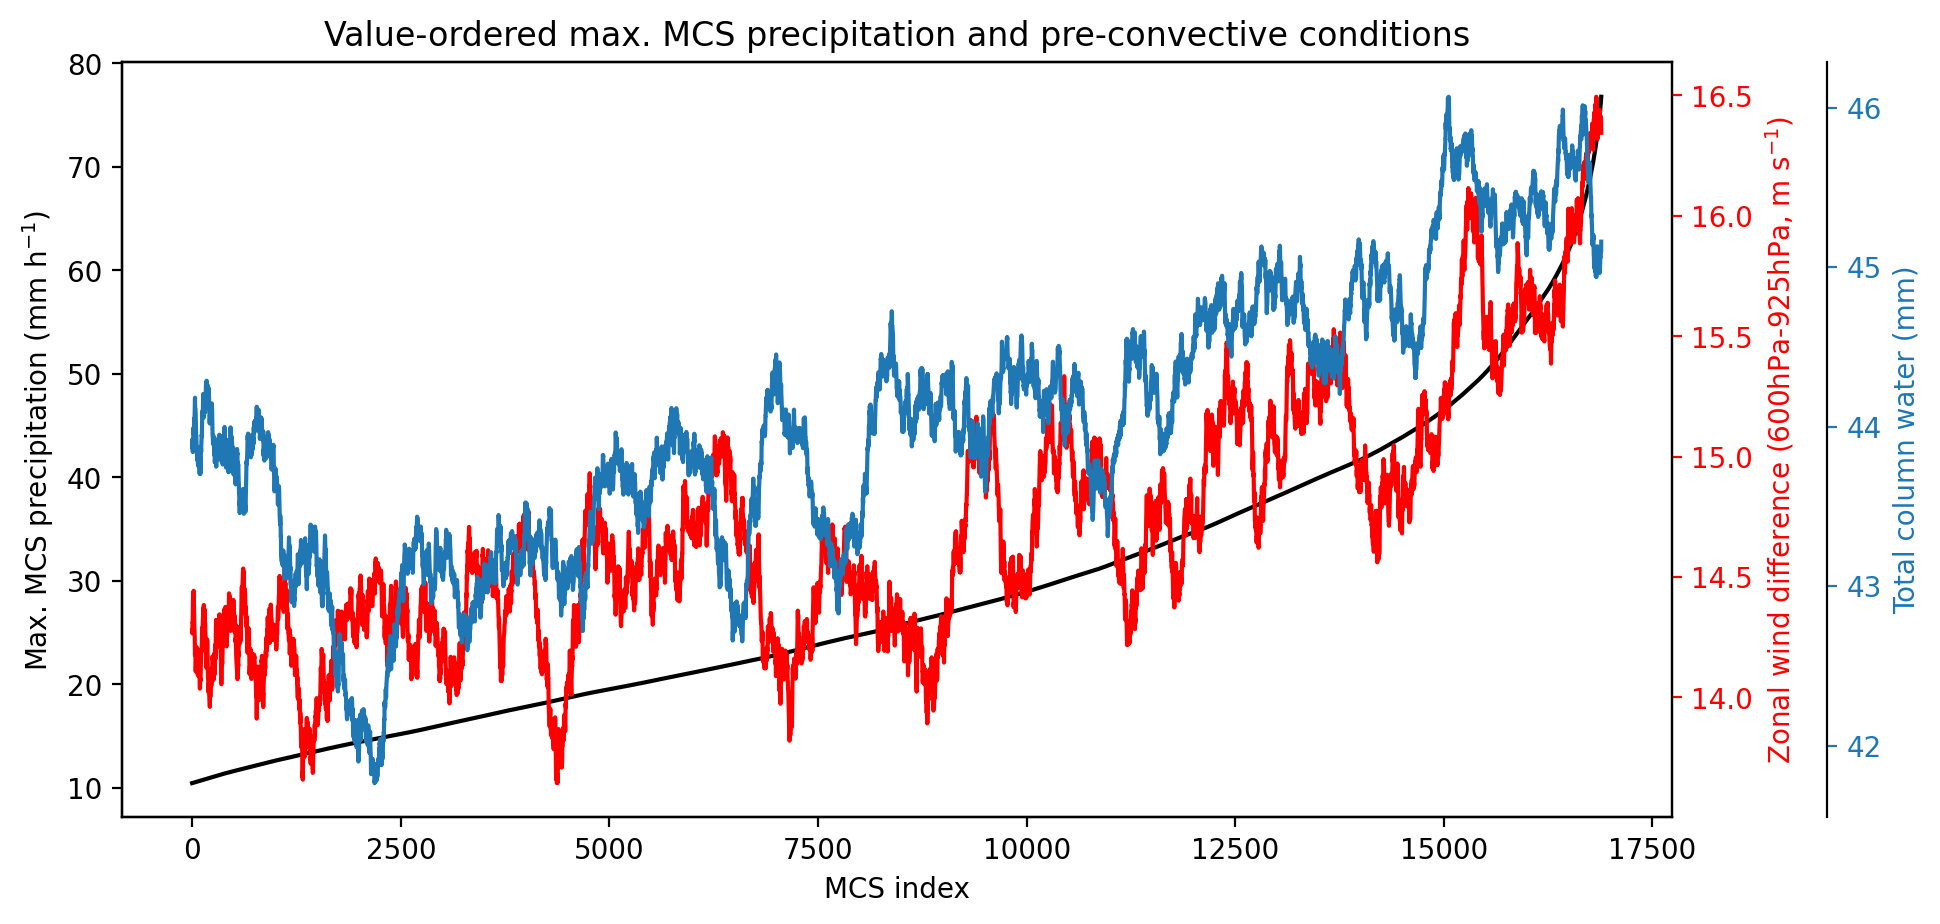

In [268]:
obsord = obs[np.isfinite(obs['prcp']) & np.isfinite(obs['shear']) & np.isfinite(obs['q925']) & np.isfinite(obs['t925'])]
inds = np.argsort(obsord['prcp'])

minus = -20000
pro = obsord['prcp'].values[inds]#[minus::]
sho = obsord['shear'].values[inds]#[minus::]
tco = obsord['tcwv'].values[inds]#[minus::]
qco = obsord['q925'].values[inds]#[minus::]
temp = obsord['t925'].values[inds]#[minus::]
qupco = obsord['q650'].values[inds]#[minus::]

f = plt.figure(figsize=(10,5), dpi=200)
ax = f.add_subplot(111)
ax2 = ax.twinx()
#ax3 = ax.twinx()
ax4 = ax.twinx()

agg = 400


# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
#ax2.spines["right"].set_position(("axes", 1.02))
#ax3.spines["right"].set_position(("axes", 1.1))
ax4.spines["right"].set_position(("axes", 1.1))

ax.plot(moving_average(pro,agg), label='prcp', color='k')

p4, = ax4.plot(moving_average(tco,agg), label='tcwv')
p2, = ax2.plot(moving_average(sho,agg), label='shear', color='r')
#p3, = ax3.plot(moving_average(qco,500), label='q925', color='purple')
#p4, = ax4.plot(moving_average(temp,500), label='t925', color='orange')

ax2.yaxis.label.set_color(p2.get_color())
#ax3.yaxis.label.set_color(p3.get_color())
ax4.yaxis.label.set_color(p4.get_color())

tw = moving_average(tco,agg)
twd = tw[1::]-tw[0:-1]
sw = moving_average(sho,agg)
swd = sw[1::]-sw[0:-1]

print(stats.pearsonr(twd,swd))

ax.set_ylabel('Max. MCS precipitation (mm h$^{-1}$)')
ax2.set_ylabel('Zonal wind difference (600hPa-925hPa, m s$^{-1}$)')
ax4.set_ylabel('Total column water (mm)')


ax2.tick_params(axis='y', colors=p2.get_color())
#ax3.tick_params(axis='y', colors=p3.get_color() )
ax4.tick_params(axis='y', colors=p4.get_color())

ax.set_title('Value-ordered max. MCS precipitation and pre-convective conditions')
ax.set_xlabel('MCS index')

#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/ordered_MCSs/maxP_ordered_15000.jpg')

(0.11392202966361681, 0.2716553609878901)


Text(0.5, 0, 'MCS index')

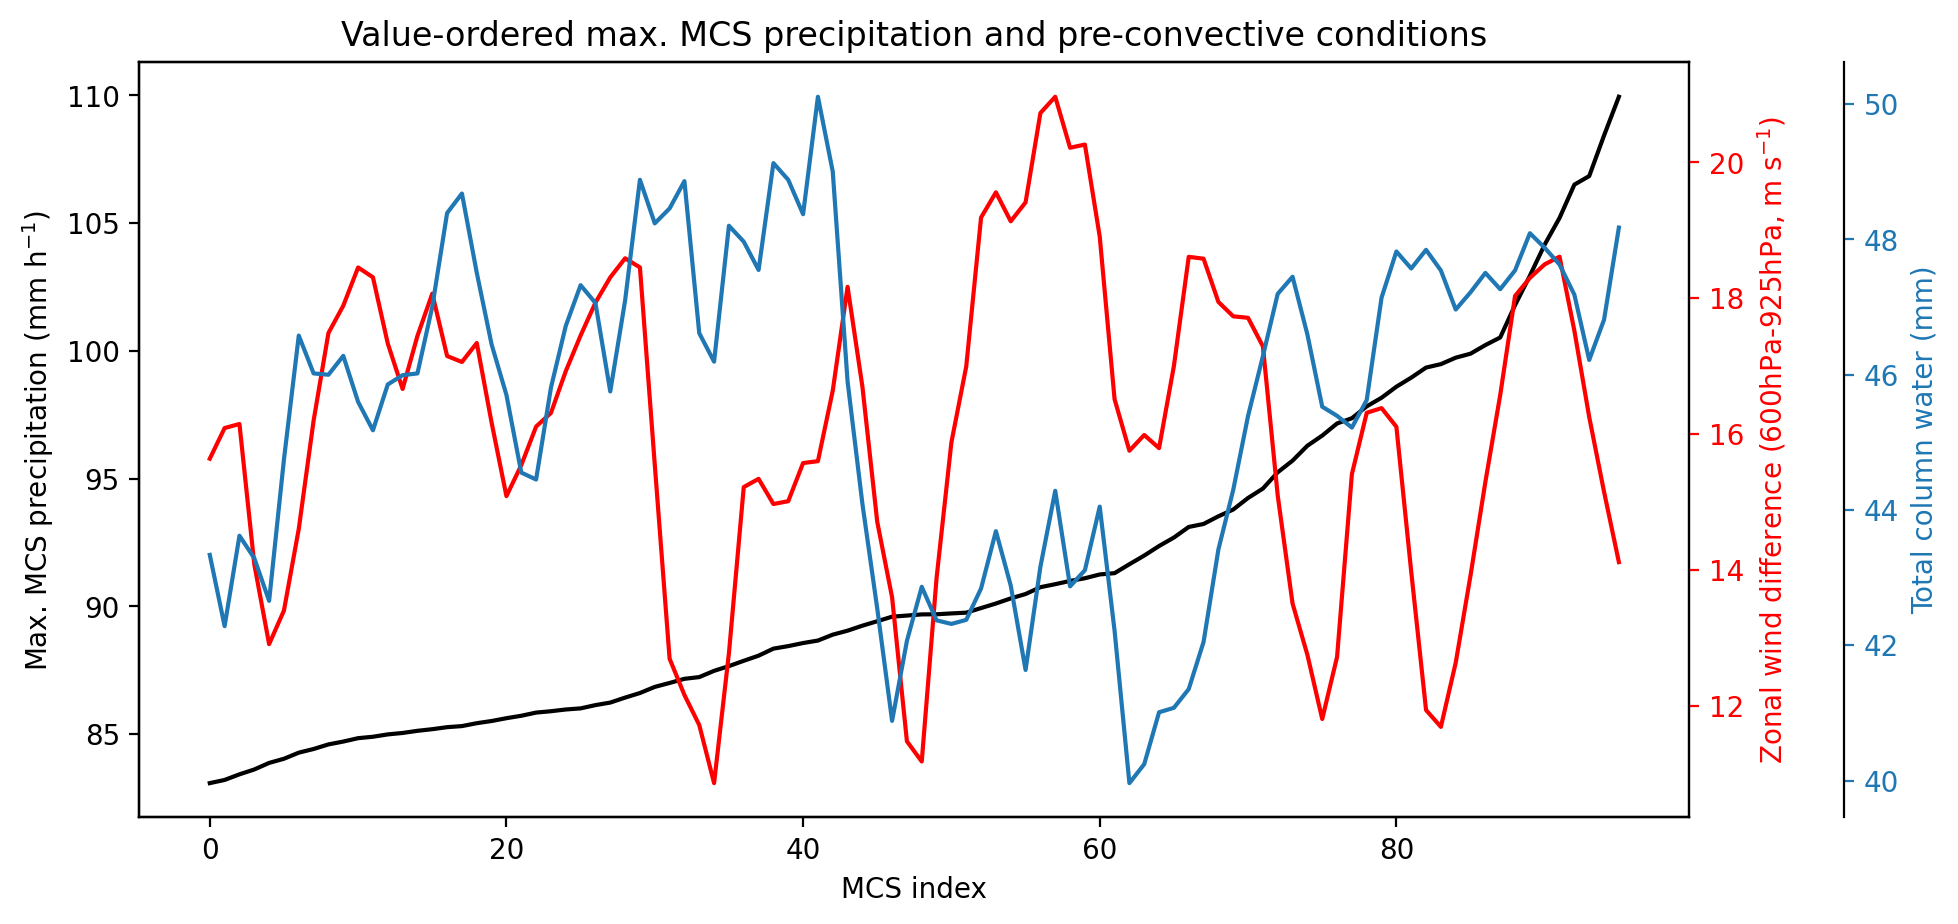

In [247]:
obsord = obs[np.isfinite(obs['prcp']) & np.isfinite(obs['shear']) & np.isfinite(obs['q925']) & np.isfinite(obs['t925'])]
inds = np.argsort(obsord['prcp'])

minus = -100
pro = obsord['prcp'].values[inds][minus::]
sho = obsord['shear'].values[inds][minus::]
tco = obsord['tcwv'].values[inds][minus::]
qco = obsord['q925'].values[inds][minus::]
temp = obsord['t925'].values[inds][minus::]
qupco = obsord['q650'].values[inds][minus::]

f = plt.figure(figsize=(10,5), dpi=200)
ax = f.add_subplot(111)
ax2 = ax.twinx()
#ax3 = ax.twinx()
ax4 = ax.twinx()

agg = 5


# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
#ax2.spines["right"].set_position(("axes", 1.02))
#ax3.spines["right"].set_position(("axes", 1.1))
ax4.spines["right"].set_position(("axes", 1.1))

ax.plot(moving_average(pro,agg), label='prcp', color='k')

p4, = ax4.plot(moving_average(tco,agg), label='tcw')
p2, = ax2.plot(moving_average(sho,agg), label='shear', color='r')
#p3, = ax3.plot(moving_average(qco,500), label='q925', color='purple')
#p4, = ax4.plot(moving_average(temp,500), label='t925', color='orange')

ax2.yaxis.label.set_color(p2.get_color())
#ax3.yaxis.label.set_color(p3.get_color())
ax4.yaxis.label.set_color(p4.get_color())

tw = moving_average(tco,agg)
twd = tw[1::]-tw[0:-1]
sw = moving_average(sho,agg)
swd = sw[1::]-sw[0:-1]

print(stats.pearsonr(twd,swd))

ax.set_ylabel('Max. MCS precipitation (mm h$^{-1}$)')
ax2.set_ylabel('Zonal wind difference (600hPa-925hPa, m s$^{-1}$)')
ax4.set_ylabel('Total column water (mm)')


ax2.tick_params(axis='y', colors=p2.get_color())
#ax3.tick_params(axis='y', colors=p3.get_color() )
ax4.tick_params(axis='y', colors=p4.get_color())

ax.set_title('Value-ordered max. MCS precipitation and pre-convective conditions')
ax.set_xlabel('MCS index')

#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/ordered_MCSs/maxP_ordered.jpg')

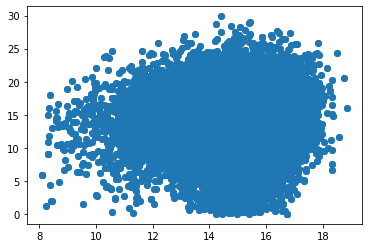

In [108]:
plt.scatter(obs.q925, obs.shear)

In [35]:
def gauss(data, sigma):
    sigma=sigma                  # standard deviation for Gaussian kernel
    truncate=4.0               # truncate filter at this many sigmas

    U=data       # random array...

    V=U.copy()
    V[np.isnan(U)]=0
    VV=ndimage.gaussian_filter(V,sigma=sigma,truncate=truncate)

    W=0*U.copy()+1
    W[np.isnan(U)]=0
    WW=ndimage.gaussian_filter(W,sigma=sigma,truncate=truncate)

    Z=VV/WW
    return Z

In [36]:
# sbin = np.linspace(0,26.8,25)
# tbin = np.linspace(27,57,25)

sbin = np.linspace(0,26.7,28) #28
#tbin = np.linspace(27,57,28)

q1 = 0.8 #0.8
q2 = 99.5#99.5
#sbin = np.linspace(np.percentile(obs.shear,q1) ,np.max([np.percentile(obs.shear,q2),np.percentile(cp4.shear,q2)]),28) #np.min([np.percentile(obs.shear,q1),np.percentile(cp4.shear,q1)])
tbin = np.linspace(np.min([np.percentile(obs.tcwv,q1),np.percentile(cp4.tcwv,q1)]) ,np.max([np.percentile(obs.tcwv,q2),np.percentile(cp4.tcwv,q2)]),26)

testbins = [sbin,tbin]
func1 = lambda y: np.percentile(y,95, interpolation='nearest') #np.percentile(y, 95)
func2 = lambda y: np.sum(np.isfinite(y))
func3 = lambda y: np.sum(y>40)
func4 = lambda y: np.nanmean(y)
ret = binned_statistic_2d(obs['shear'], obs['tcwv'], obs['prcp'], statistic=func1, bins=testbins)  #### func 1 for ENDGAME plot
count = binned_statistic_2d(obs['shear'], obs['tcwv'], obs['prcp'], statistic=func2, bins=testbins)
thresh = binned_statistic_2d(obs['shear'], obs['tcwv'], obs['prcp'], statistic=func3, bins=testbins)

/tmp/ipykernel_11204/3775315489.py:13: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  func1 = lambda y: np.percentile(y,95, interpolation='nearest') #np.percentile(y, 95)
/tmp/ipykernel_11204/3775315489.py:13: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  func1 = lambda y: np.percentile(y,95, interpolation='nearest') #np.percentile(y, 95)


In [37]:
# # sbin = np.linspace(0,26.8,25)
# # tbin = np.linspace(27,57,25)

# sbin = np.linspace(0,26.7,28) #28
# #tbin = np.linspace(27,57,28)

# q1 = 0.2 #0.8
# q2 = 99.8#99.5
# sbin = np.linspace(np.percentile(obs.shear,q1) ,np.max([np.percentile(obs.shear,q2),np.percentile(cp4.shear,q2)]),28) #np.min([np.percentile(obs.shear,q1),np.percentile(cp4.shear,q1)])
# tbin = np.linspace(np.min([np.percentile(obs.tcwv,q1),np.percentile(cp4.tcwv,q1)]) ,np.max([np.percentile(obs.tcwv,q2),np.percentile(cp4.tcwv,q2)]),28)

# testbins = [sbin,tbin]
# func1 = lambda y: np.percentile(y, 95)
# func2 = lambda y: np.sum(np.isfinite(y))
# ret = binned_statistic_2d(obs['shear'], obs['tcwv'], obs['prcp'], statistic=func1, bins=testbins)
# count = binned_statistic_2d(obs['shear'], obs['tcwv'], obs['prcp'], statistic=func2, bins=testbins)

In [38]:
ret4 = binned_statistic_2d(cp4['shear'], cp4['tcwv'], cp4['prcp'], statistic=func1, bins=testbins)
count4 = binned_statistic_2d(cp4['shear'], cp4['tcwv'], cp4['prcp'], statistic=func1, bins=testbins)

/tmp/ipykernel_11204/3775315489.py:13: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  func1 = lambda y: np.percentile(y,95, interpolation='nearest') #np.percentile(y, 95)
/tmp/ipykernel_11204/3775315489.py:13: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  func1 = lambda y: np.percentile(y,95, interpolation='nearest') #np.percentile(y, 95)
/tmp/ipykernel_11204/3775315489.py:13: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to 

In [39]:
def run_small(data, count, testbins, axis=0):
    
    dd = gauss(data.statistic.T, 0.6)
    invalid = count.statistic.T < 10
    dd[invalid] = np.nan
    
    mean = np.nanmean(dd,axis=axis)
    val = np.nansum(np.isfinite(dd),axis=axis)
    
    mean[val<4] = np.nan
    
    perc = np.nanpercentile(dd, [10,90], axis=axis)
    
    def weighted_regress(bins,data, pval):
        import statsmodels.api as sm
        data = np.array(data)
        pos = np.isfinite(data)
        inbins = bins#[pos]
        indata = data#[pos]
        inval = np.array(pval)#[pos]
        X = sm.add_constant(inbins)
        weight = inval / np.sum(inval)
        #ipdb.set_trace()
        return sm.WLS(indata,X, missing='drop', weights=weight).fit() # #, weights=weight
    
    sbin = testbins[axis]
    bins = np.round(sbin[0:-1]+((sbin[1::]-sbin[0:-1])/2),2)
    fillmean = mean.copy()
    fillmean[np.isnan(fillmean)]=0

    val[np.isnan(fillmean)]=0
    wls_model = weighted_regress(bins[0:-3], fillmean[0:-3], val[0:-3])

    intercept = wls_model.params[0] #  intercept
    slope = wls_model.params[1] #  slope
    r_value = wls_model.rsquared  #rsquared
    
    #ipdb.set_trace()
    
    print(wls_model.summary())
    
    
   # ipdb.set_trace()
    
    odic = {
        'slope' : slope,
        'intercept' : intercept,
        'rval' : r_value,
        'pmean' :mean,
        'p90' : perc[0],
        'p10' : perc[1],
        'bins' : bins,
        'std_est' : wls_model.bse[0],
        'valid' : val,
        'model' : wls_model
    }
    
    return odic

In [40]:
def run_small_2d(data, count, testbins):
    
    dd = gauss(data.statistic.T, 0.4)
    invalid = count.statistic.T < 10
    dd[invalid] = np.nan
    
    
    mean_x = np.nanmean(dd,axis=0)
    val_x = np.nansum(np.isfinite(dd),axis=0)
    mean_x[val_x<4] = np.nan
    perc_x = np.nanpercentile(dd, [10,90], axis=0)
    
    mean_y = np.nanmean(dd,axis=1)
    val_y = np.nansum(np.isfinite(dd),axis=1)
    mean_y[val_y<4] = np.nan
    perc_y = np.nanpercentile(dd, [10,90], axis=1)
    
    
    sbin = testbins[0]
    tbin = testbins[1]
    ssbins = np.round(sbin[0:-1]+((sbin[1::]-sbin[0:-1])/2),2)
    ttbins = np.round(tbin[0:-1]+((tbin[1::]-tbin[0:-1])/2),2)
    
    X,Y = np.meshgrid(ssbins, ttbins)

    # First we need to flatten the data: it's 2D layout is not relevent.
    counts = count.statistic.T
    Z = dd.flatten()
    X = X.flatten()
    Y = Y.flatten()
    inval = counts.flatten()
    
   
    ################################################################
    # For 3d plots. This import is necessary to have 3D plotting below
    from mpl_toolkits.mplot3d import Axes3D
    import pandas
    # For statistics. Requires statsmodels 5.0 or more
    from statsmodels.formula.api import wls
    # Analysis of Variance (ANOVA) on linear models
    from statsmodels.stats.anova import anova_lm
    # Convert the data into a Pandas DataFrame to use the formulas framework
    # in statsmodels


    data = pandas.DataFrame({'x': X, 'y': Y, 'z': Z})
    weight = inval / np.sum(inval)
    # Fit the model
    model = wls("z ~ x + y", data, weights=weight, missing='drop').fit()

    # Print the summary
    print(model.summary())

    print("\nRetrieving manually the parameter estimates:")
    print(model._results.params)
    # should be array([-4.99754526,  3.00250049, -0.50514907])

    # Peform analysis of variance on fitted linear model
    anova_results = anova_lm(model)

    print('\nANOVA results')
    print(anova_results)

    plt.show()
    ################################################################
    
    odic = {
        'model' : model,
        'pmean_x' :mean_x,
        'pmean_y' :mean_y,
        'p90_x' : perc_x[0],
        'p10_x' : perc_x[1],
        'p90_y' : perc_y[0],
        'p10_y' : perc_y[1],
        'bins_x' : ssbins,
        'bins_y' : ttbins
    }
    
    return odic

In [41]:
tdicobs = run_small(ret, count, testbins,axis=1)
sdicobs = run_small(ret, count, testbins,axis=0)
tdic4 = run_small(ret4, count4, testbins,axis=1)
sdic4 = run_small(ret4, count4, testbins,axis=0)

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.787
Model:                            WLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     74.03
Date:                Mon, 07 Aug 2023   Prob (F-statistic):           3.72e-08
Time:                        15:48:29   Log-Likelihood:                   -inf
No. Observations:                  22   AIC:                               inf
Df Residuals:                      20   BIC:                               inf
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.1366      3.360      2.124      0.0

/tmp/ipykernel_11204/3315243852.py:7: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(dd,axis=axis)
/home/ck/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/ck/miniconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:807: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))
/tmp/ipykernel_11204/3315243852.py:7: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(dd,axis=axis)
/home/ck/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/ck/miniconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:807: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))
/tmp/ipykernel_11204/1081595332.py:15: Runti

In [42]:
def binning_hist(bins, shape):
    scat = np.repeat(bins,shape[1],axis=0).reshape(shape)
    return scat

In [43]:
tb = testbins[1][0:-1] + (testbins[1][1::] - testbins[1][0:-1])/2
sb = testbins[0][0:-1] + (testbins[0][1::] - testbins[0][0:-1])/2

In [44]:
len(tb)

25

In [45]:
wgrid = binning_hist(tb,ret.statistic.T.shape)
sgrid = binning_hist(sb,ret.statistic.shape)

In [46]:
np.nanmean(ret.statistic.T, axis=0).shape

(27,)

In [47]:
def find_cumsum(x, thresh):
    pos = np.where(np.cumsum(np.sort(x)[::-1])>=thresh)
    val = (np.sort(x)[::-1])[pos[0][0]]
    #ipdb.set_trace()
    return np.where(x>=val)[0]

In [48]:
frac4_tcw = np.sum(count4.statistic.T,axis=1)/np.sum(count4.statistic)
frac4_shear = np.sum(count4.statistic.T,axis=0)/np.sum(count4.statistic)

frac_tcw = np.sum(count.statistic.T,axis=1)/np.sum(count.statistic)
frac_shear = np.sum(count.statistic.T,axis=0)/np.sum(count.statistic)

In [49]:
def density_plot(v1,v2):
    xy = np.vstack([v1, v2])
    z = gaussian_kde(xy)(xy)
    data = z / (z.max() - z.min())

#     rr = stats.pearsonr(v1,v2)
#     print('pears', stats.pearsonr(v1,v2))
    
    return data

In [50]:
mask = np.isfinite(wgrid) & np.isfinite(ret.statistic.T)
dens = density_plot(wgrid[mask],ret.statistic.T[mask])

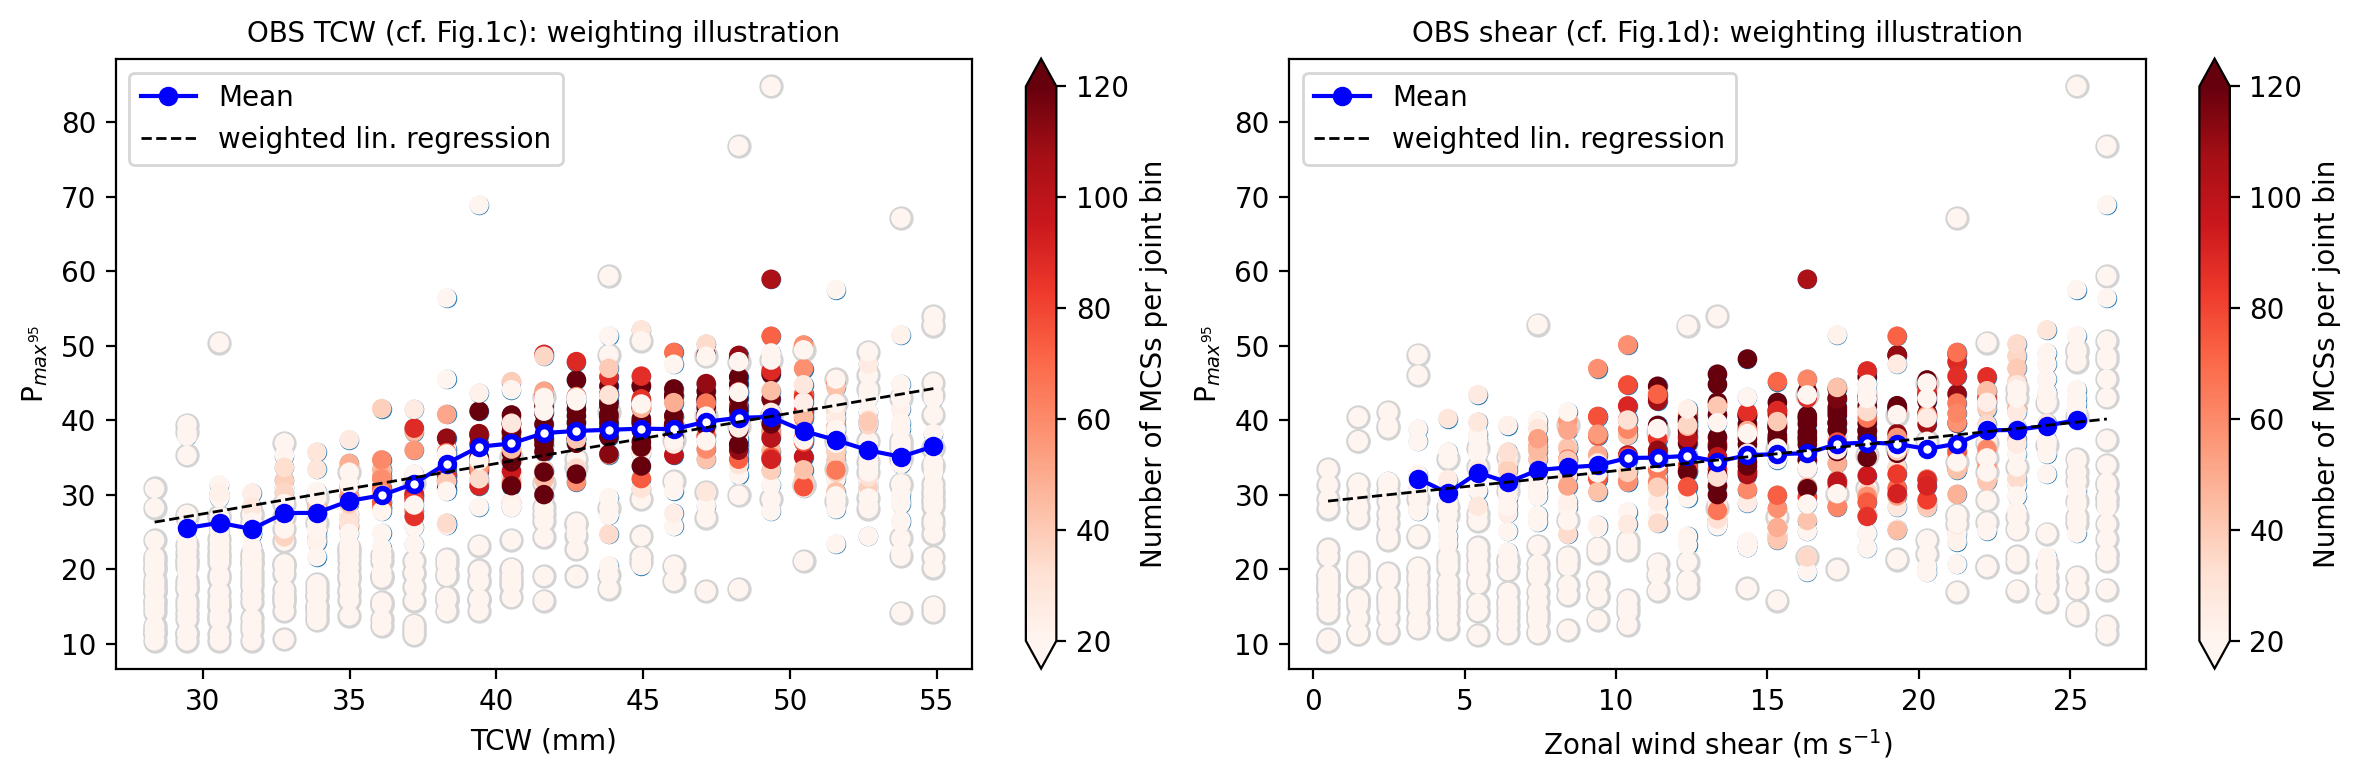

In [51]:
f = plt.figure(figsize=(12,4), dpi=200)
ax = f.add_subplot(1,2,2)
plt.scatter(sgrid,gauss(ret.statistic,0.4), color='C0')
plt.scatter(sgrid[count.statistic<10],gauss(ret.statistic,0.4)[count.statistic<10], color='lightgrey', s=60)
#plt.scatter(wgrid[mask],ret.statistic.T[mask], c=dens, cmap='viridis')
mp = plt.scatter(sgrid,gauss(ret.statistic,0.4), c=count.statistic, cmap='Reds', vmin=20, vmax=120)
cbar = plt.colorbar(mp, extend='both')
cbar.set_label('Number of MCSs per joint bin')

plt.plot(sdicobs['bins'],sdicobs['pmean'], color='blue', label='Mean', marker='o')
indx = find_cumsum(frac_shear, 0.8)
plt.plot(sdicobs['bins'][indx],sdicobs['pmean'][indx],marker='o', color='white', markersize=2, linestyle='')
plt.plot(sdicobs['bins'],sdicobs['slope']*sdicobs['bins']+sdicobs['intercept'], linestyle='dashed', color='k', linewidth=1, label='weighted lin. regression')
plt.ylabel('P$_{max^{95}}$')
plt.xlabel('Zonal wind shear (m s$^{-1}$)')
plt.title('OBS shear (cf. Fig.1d): weighting illustration', fontsize=10)
plt.legend()
plt.tight_layout()
plt.legend()
ax = f.add_subplot(1,2,1)
#count.statistic.T[:, -5] = count.statistic.T[:, -5]-3
#count.statistic.T[count.statistic.T>30] = count.statistic.T[count.statistic.T>30]+10
plt.scatter(wgrid,gauss(ret.statistic.T,0.4), color='C0')
plt.scatter(wgrid[count.statistic.T<10],gauss(ret.statistic.T,0.4)[count.statistic.T<10], color='lightgrey', s=60)
#plt.scatter(wgrid[mask],ret.statistic.T[mask], c=dens, cmap='viridis')
rett = np.copy(count.statistic.T)
rett[(wgrid<42)&(count.statistic.T>25)] = rett[(wgrid<42)&(count.statistic.T>25)]+35
mp = plt.scatter(wgrid,gauss(ret.statistic.T,0.4), c=count.statistic.T, cmap='Reds', vmin=20, vmax=120)
cbar = plt.colorbar(mp, extend='both')
cbar.set_label('Number of MCSs per joint bin')

plt.plot(tdicobs['bins'],tdicobs['pmean'], color='blue', label='Mean', marker='o')
indx = find_cumsum(frac_tcw, 0.8)
plt.plot(tdicobs['bins'][indx-2],tdicobs['pmean'][indx-2],marker='o', color='white', markersize=2, linestyle='')
plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=1, label='weighted lin. regression')
plt.ylabel('P$_{max^{95}}$')
plt.xlabel('TCW (mm)')
plt.title('OBS TCW (cf. Fig.1c): weighting illustration', fontsize=10)
plt.legend()
plt.tight_layout()
# ax = f.add_subplot(1,3,3)
# plt.scatter(wgrid[count.statistic.T>25],ret.statistic.T[count.statistic.T>25], color='seagreen')
# linslope, linintercept, r_value, p_value, std_err = linregress(wgrid[count.statistic.T>25], ret.statistic.T[count.statistic.T>25])
# plt.plot(tdicobs['bins'],linslope*tdicobs['bins']+linintercept, linestyle='dashed', color='k', linewidth=1)
# plt.text(30,80, str(np.round(r_value,2))+', slope: '+str(np.round(linslope,2)))
#plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_'+tag+'_15km_'+ttag+'_scatter_REVexample.jpg')

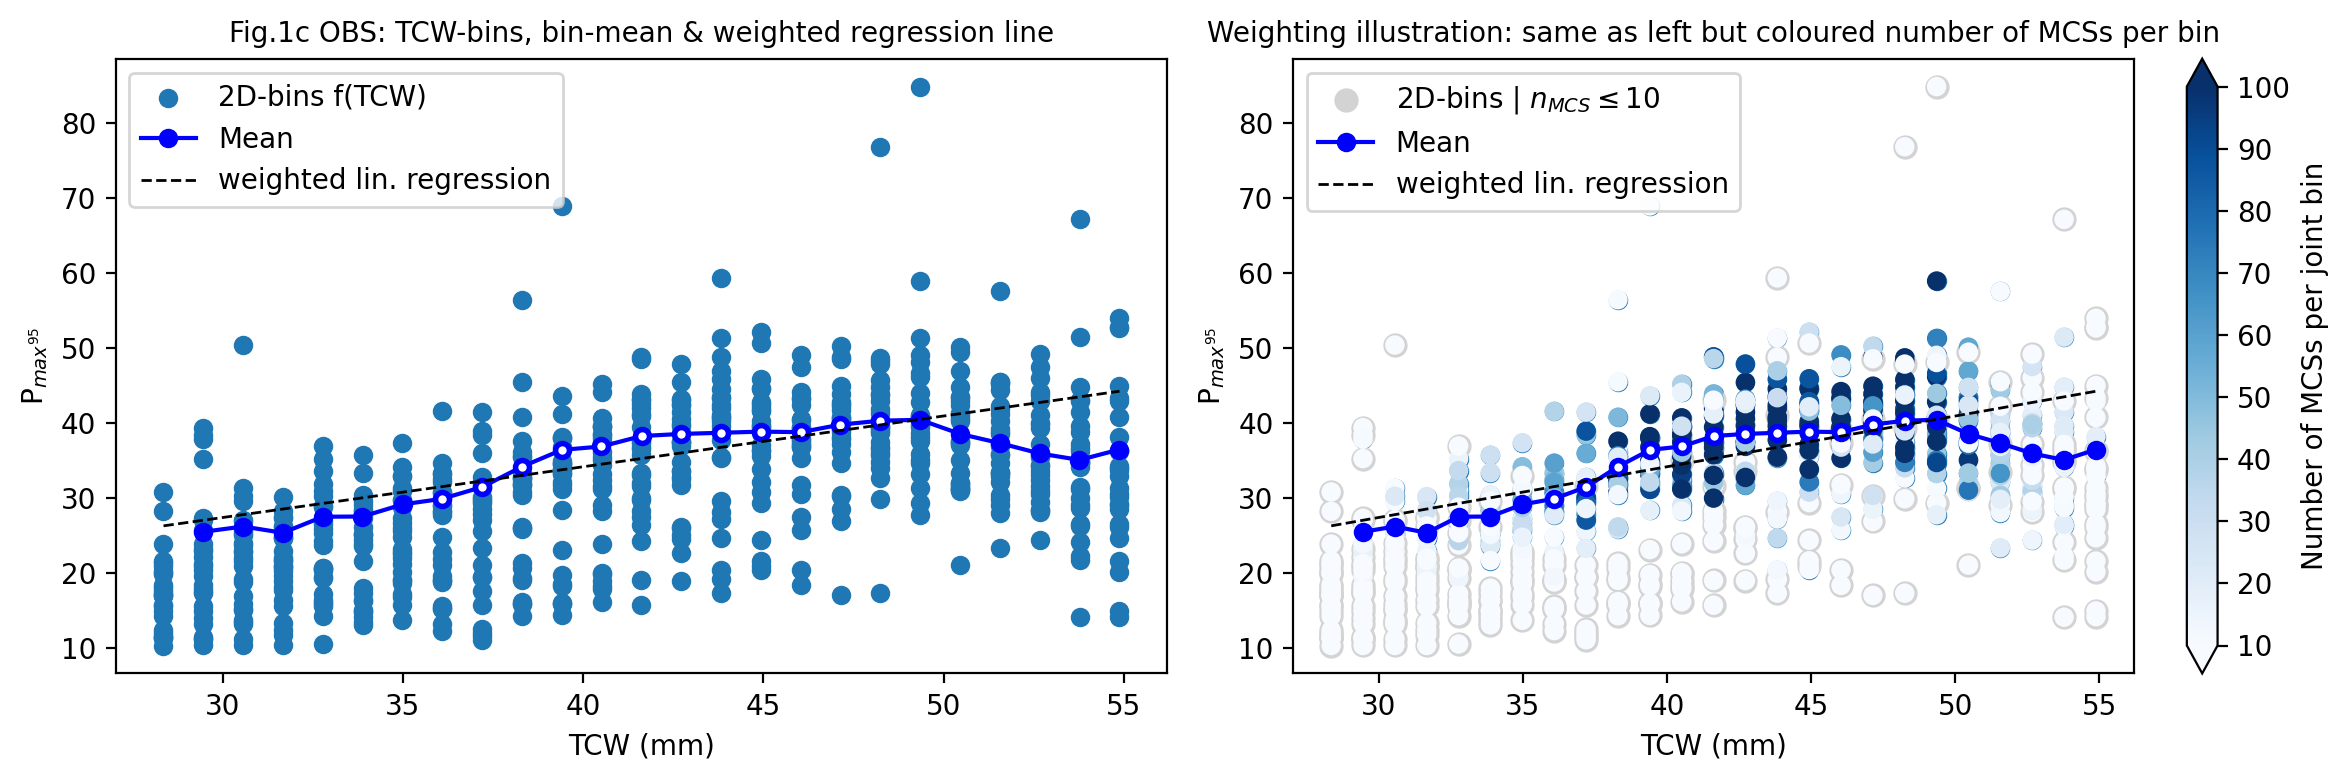

In [52]:
f = plt.figure(figsize=(12,4), dpi=200)
ax = f.add_subplot(1,2,1)
plt.scatter(wgrid,gauss(ret.statistic.T,0.4), color='C0', label='2D-bins f(TCW)')
plt.plot(tdicobs['bins'],tdicobs['pmean'], color='blue', label='Mean', marker='o')
indx = find_cumsum(frac_tcw, 0.8)
plt.plot(tdicobs['bins'][indx-2],tdicobs['pmean'][indx-2],marker='o', color='white', markersize=2, linestyle='')
plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=1, label='weighted lin. regression')
plt.ylabel('P$_{max^{95}}$')
plt.xlabel('TCW (mm)')
plt.title('Fig.1c OBS: TCW-bins, bin-mean & weighted regression line', fontsize=10)
plt.legend()

# from endgame import hist2d
# outdic = hist2d.var2_binning_mean(count.statistic.T, gauss(ret.statistic.T,0.4), np.arange(0,150,5))
# #from scipy.ndimage import gaussian_filter1d
# arr = np.array(outdic['y'])
# arr[np.isnan(arr)]=49
# plt.plot(outdic['xbins'], arr, marker='o')


ax = f.add_subplot(1,2,2)
plt.scatter(wgrid,gauss(ret.statistic.T,0.4), color='C0')
plt.scatter(wgrid[count.statistic.T<10],gauss(ret.statistic.T,0.4)[count.statistic.T<10], color='lightgrey', label='2D-bins | $n_{MCS} \leq$10', s=60)
#plt.scatter(wgrid[mask],ret.statistic.T[mask], c=dens, cmap='viridis')
mp = plt.scatter(wgrid,gauss(ret.statistic.T,0.4), c=count.statistic.T, cmap='Blues', vmin=10, vmax=100)
cbar = plt.colorbar(mp, extend='both')
cbar.set_label('Number of MCSs per joint bin')

plt.plot(tdicobs['bins'],tdicobs['pmean'], color='blue', label='Mean', marker='o')
indx = find_cumsum(frac_tcw, 0.8)
plt.plot(tdicobs['bins'][indx-2],tdicobs['pmean'][indx-2],marker='o', color='white', markersize=2, linestyle='')
plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=1, label='weighted lin. regression')
plt.ylabel('P$_{max^{95}}$')
plt.xlabel('TCW (mm)')
plt.title('Weighting illustration: same as left but coloured number of MCSs per bin', fontsize=10)
plt.legend()
plt.tight_layout()
# ax = f.add_subplot(1,3,3)
# plt.scatter(wgrid[count.statistic.T>25],ret.statistic.T[count.statistic.T>25], color='seagreen')
# linslope, linintercept, r_value, p_value, std_err = linregress(wgrid[count.statistic.T>25], ret.statistic.T[count.statistic.T>25])
# plt.plot(tdicobs['bins'],linslope*tdicobs['bins']+linintercept, linestyle='dashed', color='k', linewidth=1)
# plt.text(30,80, str(np.round(r_value,2))+', slope: '+str(np.round(linslope,2)))
#plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_'+tag+'_15km_'+ttag+'_scatter_REVexample.jpg')

In [53]:
def weighted_regress(bins,data, pval):
    import statsmodels.api as sm
    data = np.array(data)
    pos = np.isfinite(data)
    inbins = bins#[pos]
    indata = data#[pos]
    inval = np.array(pval)#[pos]
    X = sm.add_constant(inbins)
    weight = inval / np.sum(inval)
    #ipdb.set_trace()
    return sm.WLS(indata,X, missing='drop', weights=weight).fit() # #, weights=weight

In [54]:
mask = np.isfinite(wgrid.flat) & np.isfinite(ret.statistic.T.flat) & (count.statistic.T.flat>10)
wls_model = weighted_regress(wgrid.flat[mask], ret.statistic.T.flat[mask], count.statistic.T.flat[mask])

In [55]:
wls_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.226
Model:                            WLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     115.9
Date:                Mon, 07 Aug 2023   Prob (F-statistic):           7.16e-24
Time:                        15:48:45   Log-Likelihood:                -1311.8
No. Observations:                 398   AIC:                             2628.
Df Residuals:                     396   BIC:                             2636.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.7873      2.451      4.810      0.000       6.969      16.606
x1             0.5981      0.056     10.763      0.000       0.489       0.707
==============================================================================
Omnibus:                       48.979   Durbin-Watson:                   1.377
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.154
Skew:                           0.798   Prob(JB):                     7.90e-17
Kurtosis:                       4.387   Cond. No.                         402.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

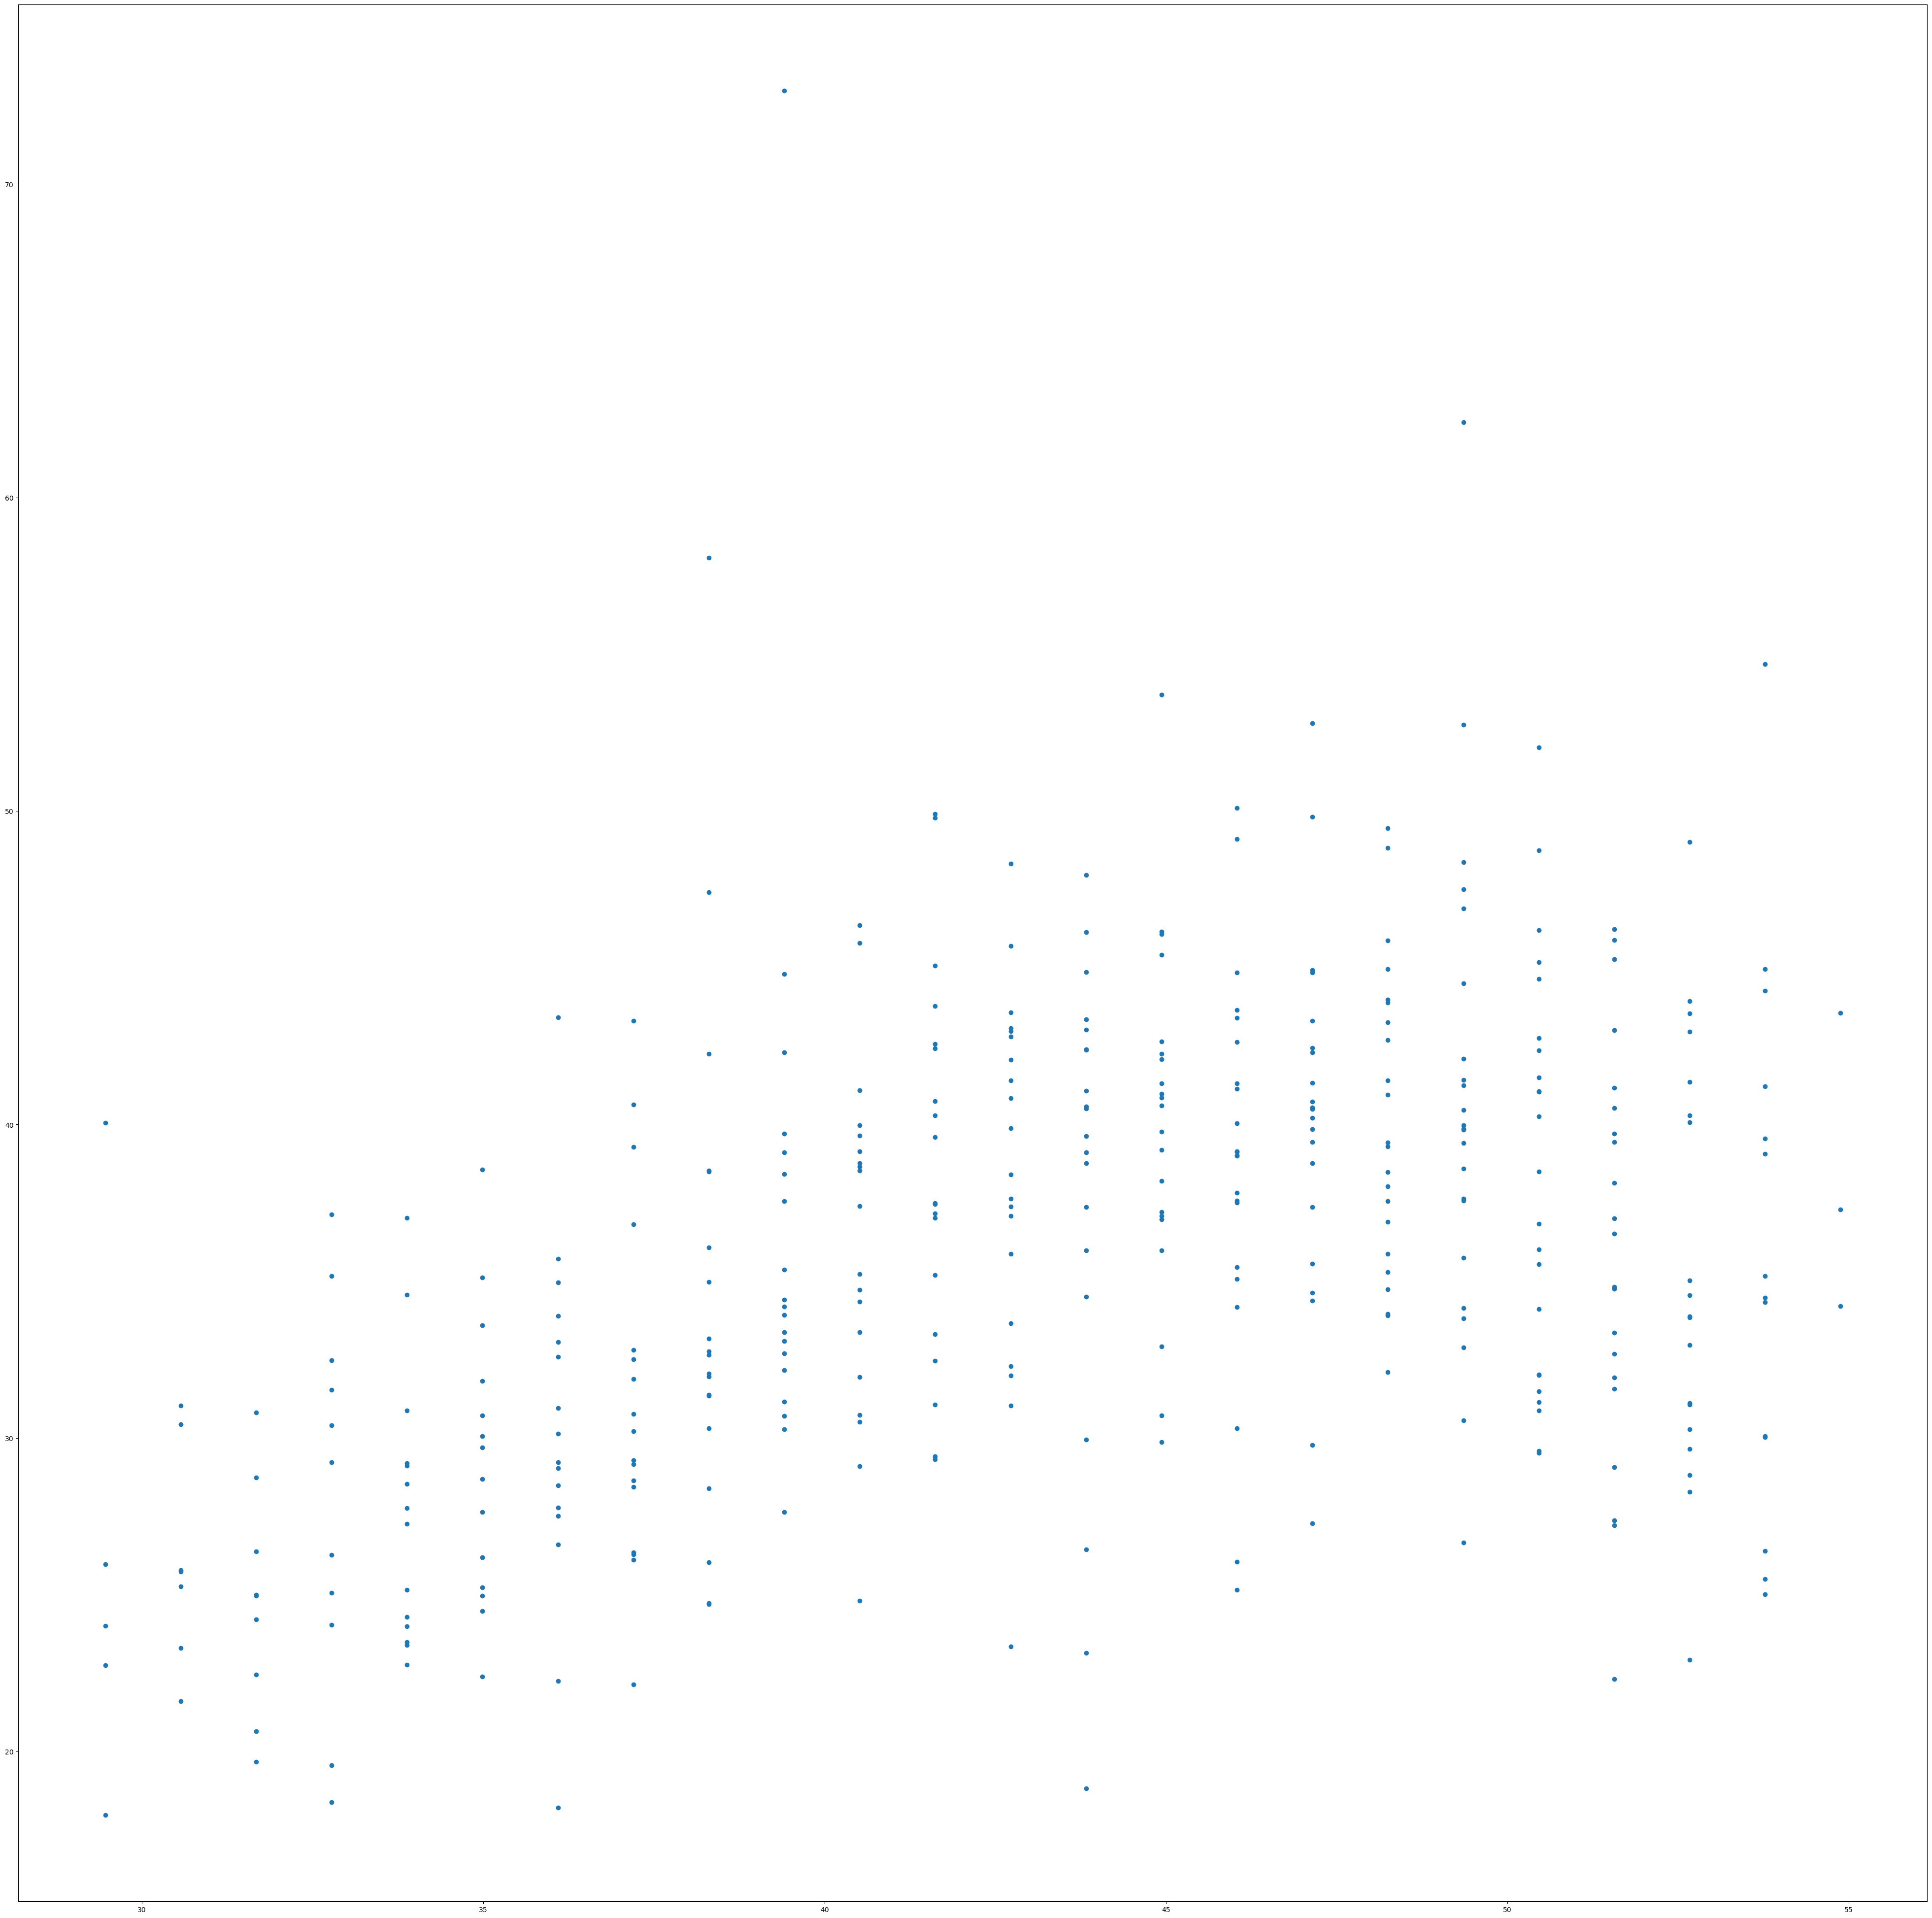

In [56]:
plt.scatter(wgrid.flat[mask],ret.statistic.T.flat[mask])

In [57]:
from utils import u_statistics as ustats

In [58]:
mask = np.isfinite(wgrid) & np.isfinite(ret.statistic.T) & np.isfinite(sgrid.T) & (count.statistic.T > 10)
r, p_e = ustats.pcor(wgrid[mask],ret.statistic.T[mask], sgrid.T[mask])
tr2 = r**2

In [59]:
r, p_e = ustats.pcor(sgrid.T[mask],ret.statistic.T[mask], wgrid[mask])
sr2 = r**2

In [60]:
print(tr2, sr2)
tr2 + sr2

0.29761773260208496 0.19286234989055953


0.4904800824926445

In [61]:
mask = np.isfinite(wgrid) & np.isfinite(ret4.statistic.T) & np.isfinite(sgrid.T) & (count4.statistic.T > 10)
r, p_e = ustats.pcor(wgrid[mask],ret4.statistic.T[mask], sgrid.T[mask])
tr2 = r**2
r, p_e = ustats.pcor(sgrid.T[mask],ret4.statistic.T[mask], wgrid[mask])
sr2 = r**2
print(tr2, sr2)
tr2 + sr2

0.2563400194990264 0.09108221627834356


0.34742223577736997

In [62]:
wls_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.226
Model:                            WLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     115.9
Date:                Mon, 07 Aug 2023   Prob (F-statistic):           7.16e-24
Time:                        15:48:52   Log-Likelihood:                -1311.8
No. Observations:                 398   AIC:                             2628.
Df Residuals:                     396   BIC:                             2636.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.7873      2.451      4.810      0.000       6.969      16.606
x1             0.5981      0.056     10.763      0.000       0.489       0.707
==============================================================================
Omnibus:                       48.979   Durbin-Watson:                   1.377
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.154
Skew:                           0.798   Prob(JB):                     7.90e-17
Kurtosis:                       4.387   Cond. No.                         402.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
count.statistic.T.shape

(25, 27)

In [64]:
rrs = stats.pearsonr(wgrid.flat[mask],ret.statistic.T.flat[mask])
print(rrs, rrs[0]**2)

ValueError: boolean index array should have 1 dimension

In [65]:
r, p_e = ustats.pcor(sgrid[mask],ret.statistic.T[mask], wgrid[mask])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 27 but corresponding boolean dimension is 25

In [66]:
r**2

0.09108221627834356

In [67]:
ret.statistic.T.shape

(25, 27)

In [75]:
dicobs = run_small_2d(ret, count, testbins)
dic4 = run_small_2d(ret4, count4, testbins)

                            WLS Regression Results                            
Dep. Variable:                      z   R-squared:                       0.425
Model:                            WLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     149.2
Date:                Mon, 07 Aug 2023   Prob (F-statistic):           3.03e-49
Time:                        15:51:07   Log-Likelihood:                -1255.2
No. Observations:                 407   AIC:                             2516.
Df Residuals:                     404   BIC:                             2528.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.6714      2.367     -1.129      0.2

/tmp/ipykernel_11204/3578868027.py:8: RuntimeWarning: Mean of empty slice
  mean_x = np.nanmean(dd,axis=0)
/home/ck/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/tmp/ipykernel_11204/3578868027.py:13: RuntimeWarning: Mean of empty slice
  mean_y = np.nanmean(dd,axis=1)
/tmp/ipykernel_11204/1081595332.py:15: RuntimeWarning: invalid value encountered in divide
  Z=VV/WW


ValueError: zero-size array to reduction operation maximum which has no identity

In [69]:
robs = stats.pearsonr(obs['tcwv'], obs['shear'])
rc4 = stats.pearsonr(cp4['tcwv'], cp4['shear'])

In [70]:
print(robs)
print(rc4)

PearsonRResult(statistic=-0.2371898524753111, pvalue=0.0)
PearsonRResult(statistic=-0.07244306487649421, pvalue=7.429546644623317e-33)


In [71]:
def func(x,y):
    return 2.3075 + 0.9421*x + 0.7397* y

In [72]:
tests = np.zeros((26,26))
for yid, y in enumerate(np.linspace(25,57,26)):
    for xid, x in enumerate(np.linspace(0,28,26)):
        tests[yid,xid] = func(x,y)

bigpos (array([], dtype=int64), array([], dtype=int64))


NameError: name 'dic4' is not defined

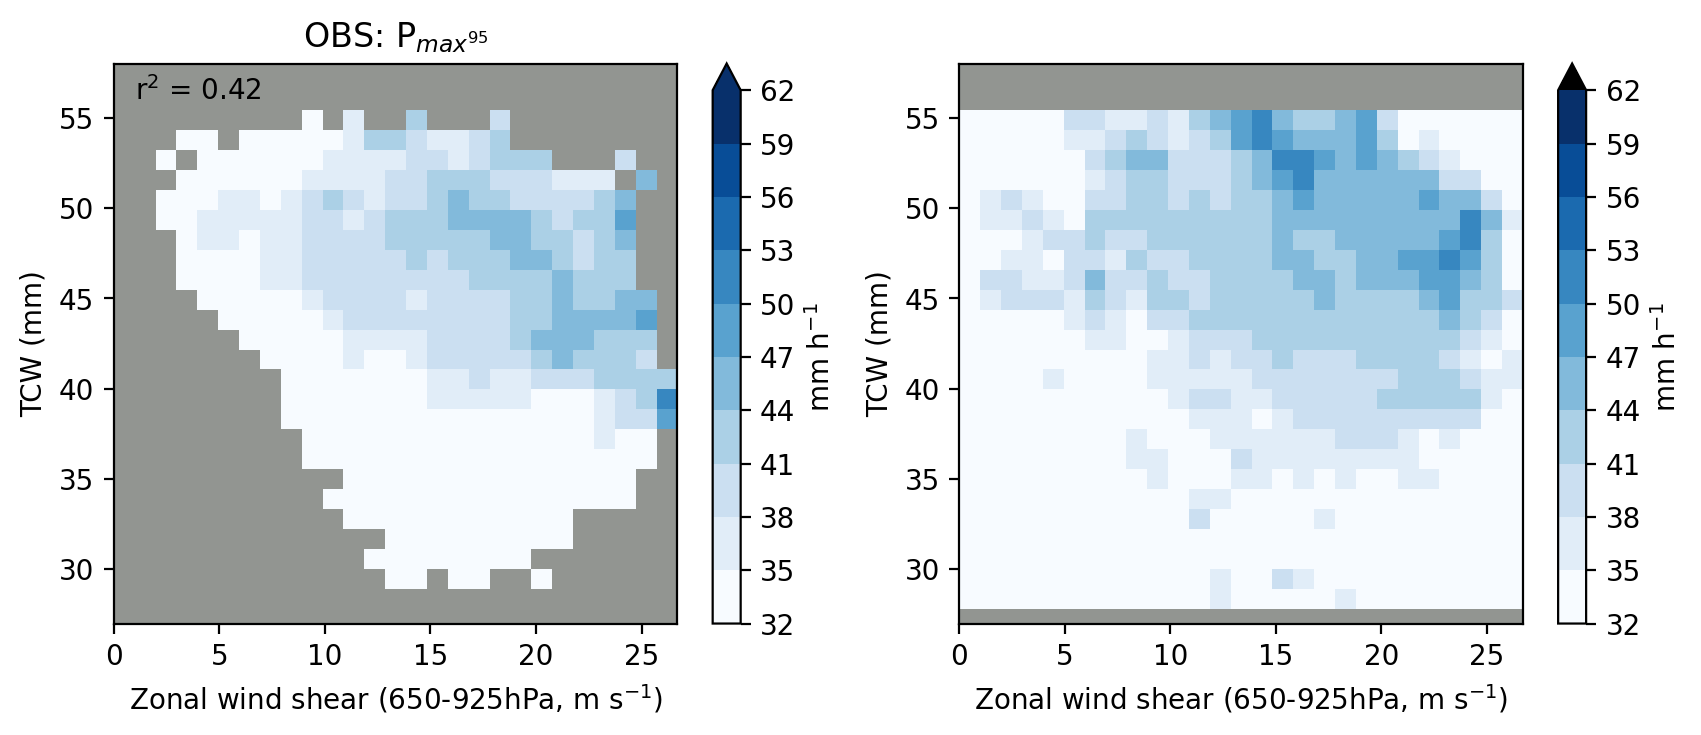

In [73]:
f = plt.figure(figsize=(10,8), dpi=200)
cmap='Blues'
vmins = 32
vmaxs = 62

pixelval = 10
cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
ax = f.add_subplot(2,2,1)
ax.set_facecolor('xkcd:grey')
dd = gauss(ret.statistic.T, 0.8)
invalid = count.statistic.T < pixelval
dd[invalid] = np.nan
bigpos = np.where(dd>60)
print('bigpos', bigpos)
mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
#plt.plot(testbins[0][bigpos[1]+1],testbins[1][bigpos[0]+1], 'o', color='grey', ms=1)
ax.set_ylim(27,58)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('TCW (mm)')
plt.text(1,56, r'r$^2$ = '+str(np.round(dicobs['model'].rsquared,2)), fontsize=10)
plt.title('OBS: P$_{max^{95}}$')

cbar = plt.colorbar(mp, ticks=np.linspace(vmins, vmaxs,11), extend='max')
cbar.set_label('mm h$^{-1}$')

ax = f.add_subplot(2,2,2)
ax.set_facecolor('xkcd:grey')
dd = gauss(ret4.statistic.T, 0.7)
invalid = count4.statistic.T < pixelval
dd[invalid] = np.nan
cmapp.set_over("black")
mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
cbar = plt.colorbar(mp, ticks=np.linspace(vmins,vmaxs,11), extend='max')
cbar.set_label('mm h$^{-1}$')
ax.set_ylim(27,58)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('TCW (mm)')
plt.text(1,56, r'r$^2$ = '+str(np.round(dic4['model'].rsquared,2)), fontsize=10)
plt.title('CP4$_H$: P$_{max^{95}}$')

ax2 = f.add_subplot(223)

plt.plot(tdicobs['bins'],tdicobs['pmean'], '-ko', label=r'OBS | $\dfrac{\partial P_{max^{95}}}{\partial TCW}$: ' + str(np.round(tdicobs['slope'],2))+r'$\pm$'+str(np.round(tdicobs['model'].bse[1],2)))
plt.fill_between(tdicobs['bins'],tdicobs['p10'],tdicobs['p90'], color='k', alpha=0.15)
plt.fill_between(tdic4['bins'],tdic4['p10'],tdic4['p90'], color='xkcd:blue', alpha=0.15)
plt.plot(tdic4['bins'],tdic4['pmean'], color='xkcd:blue', marker='o', label='CP4$_H$ | $\dfrac{\partial P_{max^{95}}}{\partial TCW}$: ' + str(np.round(tdic4['slope'],2))+'$\pm$'+str(np.round(tdic4['model'].bse[1],2)))

indx = find_cumsum(frac_tcw, 0.8)
plt.plot(tdicobs['bins'][indx-2],tdicobs['pmean'][indx-2],marker='o', color='white', markersize=2, linestyle='')
indx = find_cumsum(frac4_tcw, 0.8)
plt.plot(tdic4['bins'][indx],tdic4['pmean'][indx],marker='o', color='white', markersize=2, linestyle='')

plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)

plt.fill_between(tdic4['bins'],tdic4['p10'],tdic4['p90'], color='xkcd:blue', alpha=0.15)


plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept'], linestyle='dashed', color='k', linewidth=0.5)


plt.xlabel('TCW (mm)')
plt.ylabel('$P_{max^{95}}$ (mm h$^{-1}$)')



#plt.ylim(25,70)
ax2.xaxis.set_minor_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(MultipleLocator(5))
plt.legend(loc='upper left')





ax3 = f.add_subplot(224)
plt.plot(sdicobs['bins'],sdicobs['pmean'], '-ko', label=r'OBS | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial shear}$: ' + str(np.round(sdicobs['slope'],2))+'$\pm$'+str(np.round(sdicobs['model'].bse[1],2)))
plt.fill_between(sdicobs['bins'],sdicobs['p10'],sdicobs['p90'], color='k', alpha=0.15)
plt.fill_between(sdic4['bins'],sdic4['p10'],sdic4['p90'], color='xkcd:blue', alpha=0.15)

plt.plot(sdic4['bins'],sdic4['pmean'], color='xkcd:blue', marker='o', label=r'CP4$_{H}$ | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial shear}$: ' + str(np.round(sdic4['slope'],2))+'$\pm$'+str(np.round(sdic4['model'].bse[1],2)))

plt.plot(sdicobs['bins'],sdicobs['slope']*sdicobs['bins']+sdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)


plt.plot(sdic4['bins'],sdic4['slope']*sdic4['bins']+sdic4['intercept'], linestyle='dashed', color='k', linewidth=0.5)

indx = find_cumsum(frac_shear, 0.8)
plt.plot(sdicobs['bins'][indx-2],sdicobs['pmean'][indx-2],marker='o', color='white', markersize=2, linestyle='')
# indx = find_cumsum(frac4_shear, 0.8)
# plt.plot(sdic4['bins'][indx],sdic4['pmean'][indx],marker='o', color='white', markersize=2, linestyle='')

fdic = {'obs_shear' : sdicobs['slope'], 'cp4_shear' : sdic4['slope'], 'SE' : sdicobs['model'].bse[1]}
import pickle
pickle.dump(fdic, open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors_small.p', "wb"))

plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('$P_{max^{95}}$ (mm h$^{-1}$)')

plt.legend(loc='upper left')

plt.tight_layout()
#plt.ylim(25,70)
ax3.xaxis.set_minor_locator(MultipleLocator(5))
ax3.yaxis.set_minor_locator(MultipleLocator(5))


text = ['a', 'b', 'c', 'd']
plt.annotate(text[0], xy=(0.01, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.53, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.01, 0.49), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.53, 0.49), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)


#plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_'+tag+'_15km_'+ttag+'_NOFUTURE_50Cp90_duo_gauss_hourly2_8mm_new_modelR2.jpg')

bigpos (array([], dtype=int64), array([], dtype=int64))


IndexError: index 0 is out of bounds for axis 0 with size 0

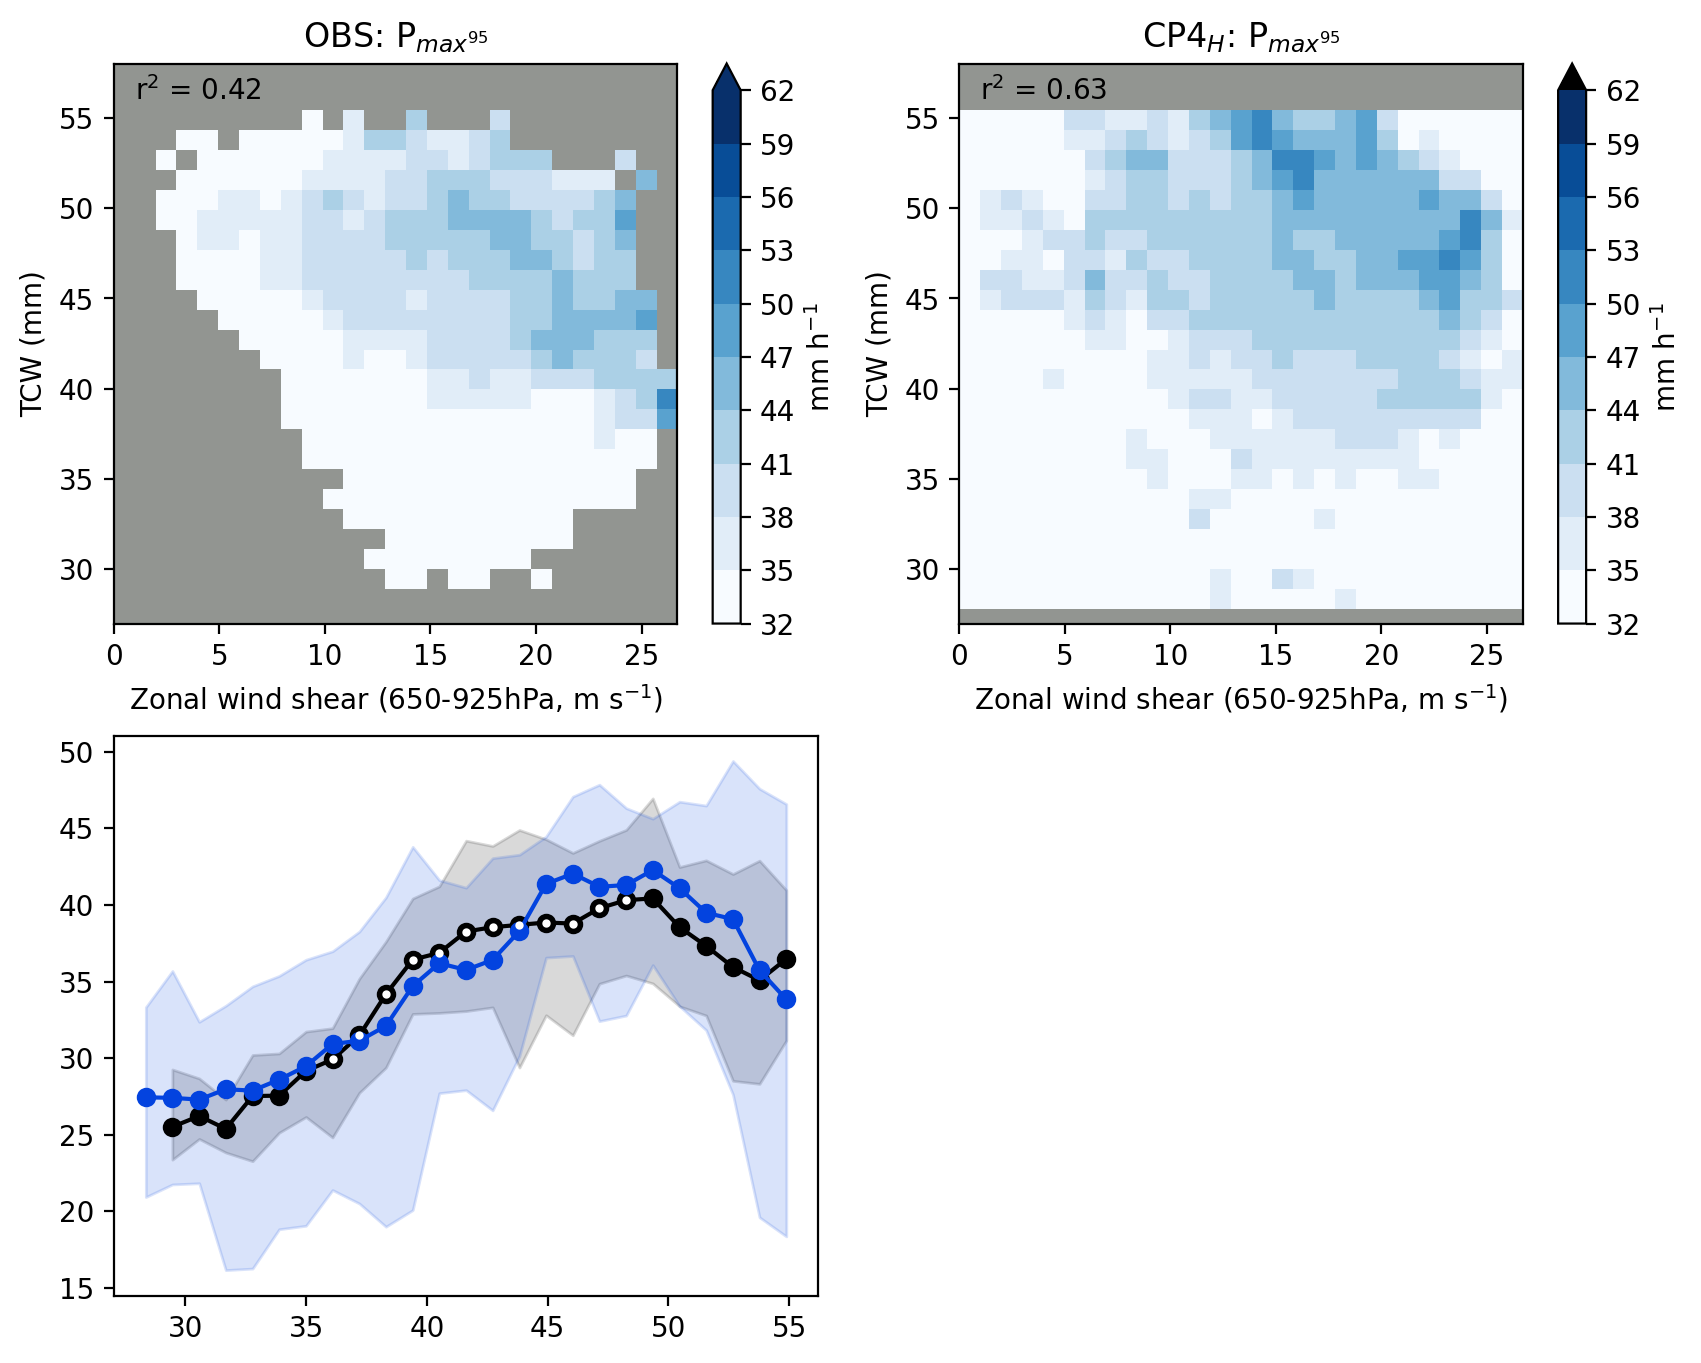

In [230]:
f = plt.figure(figsize=(10,8), dpi=200)
cmap='Blues'
vmins = 32
vmaxs = 62
pixelval = 10
cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
ax = f.add_subplot(2,2,1)
ax.set_facecolor('xkcd:grey')
dd = gauss(ret.statistic.T, 0.8)
invalid = count.statistic.T < pixelval
dd[invalid] = np.nan
bigpos = np.where(dd>60)
print('bigpos', bigpos)
mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
#plt.plot(testbins[0][bigpos[1]+1],testbins[1][bigpos[0]+1], 'o', color='grey', ms=1)
ax.set_ylim(27,58)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('TCW (mm)')
plt.text(1,56, r'r$^2$ = '+str(np.round(dicobs['model'].rsquared,2)), fontsize=10)
plt.title('OBS: P$_{max^{95}}$')

cbar = plt.colorbar(mp, ticks=np.linspace(vmins, vmaxs,11), extend='max')
cbar.set_label('mm h$^{-1}$')

ax = f.add_subplot(2,2,2)
ax.set_facecolor('xkcd:grey')
dd = gauss(ret4.statistic.T, 0.7)
invalid = count4.statistic.T < pixelval
dd[invalid] = np.nan
cmapp.set_over("black")
mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
cbar = plt.colorbar(mp, ticks=np.linspace(vmins,vmaxs,11), extend='max')
cbar.set_label('mm h$^{-1}$')
ax.set_ylim(27,58)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('TCW (mm)')
plt.text(1,56, r'r$^2$ = '+str(np.round(dic4['model'].rsquared,2)), fontsize=10)
plt.title('CP4$_H$: P$_{max^{95}}$')

ax2 = f.add_subplot(223)

ax2.plot(tdicobs['bins'],tdicobs['pmean'], '-ko', label=r'OBS | $\dfrac{\partial P_{max^{95}}}{\partial TCW}$: ' + str(np.round(tdicobs['slope'],2))+r'$\pm$'+str(np.round(tdicobs['model'].bse[1],2)))
ax2.fill_between(tdicobs['bins'],tdicobs['p10'],tdicobs['p90'], color='k', alpha=0.15)
ax2.fill_between(tdic4['bins'],tdic4['p10'],tdic4['p90'], color='xkcd:blue', alpha=0.15)
ax2.plot(tdic4['bins'],tdic4['pmean'], color='xkcd:blue', marker='o', label='CP4$_H$ | $\dfrac{\partial P_{max^{95}}}{\partial TCW}$: ' + str(np.round(tdic4['slope'],2))+'$\pm$'+str(np.round(tdic4['model'].bse[1],2)))

indx = find_cumsum(frac_tcw, 0.8)
ax2.plot(tdicobs['bins'][indx-2],tdicobs['pmean'][indx-2],marker='o', color='white', markersize=2, linestyle='')
indx = find_cumsum(frac4_tcw, 0.8)
ax2.plot(tdic4['bins'][indx],tdic4['pmean'][indx],marker='o', color='white', markersize=2, linestyle='')

#plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
ax2.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(tdicobs['bins'],(tdicobs['slope']-np.array(dicobs['model'].bse[2]))*tdicobs['bins']+tdicobs['intercept']-dicobs['model'].bse[0], linestyle='dashed', color='k', linewidth=0.5, alpha=0.15)
# plt.plot(tdicobs['bins'],(tdicobs['slope']+np.array(dicobs['model'].bse[2]))*tdicobs['bins']+tdicobs['intercept']+dicobs['model'].bse[0], linestyle='dashed', color='k', linewidth=0.5, alpha=0.15)

ax2.fill_between(tdic4['bins'],tdic4['p10'],tdic4['p90'], color='xkcd:blue', alpha=0.15)


ax2.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
# ax22 = ax2.twinx()
# ax22.plot(tdic4['bins'], np.sum(count4.statistic.T,axis=1), color='lightblue')

# plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept']+tdicobs['std_est']*2, linestyle='dotted', color='grey', linewidth=0.5)
# plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept']-tdicobs['std_est']*2, linestyle='dotted', color='grey', linewidth=0.5)

# plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept']+tdic4['std_est']*2, linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept']-tdic4['std_est']*2, linestyle='dashed', color='k', linewidth=0.5)
ax2.set_xlabel('TCW (mm)')
ax2.set_ylabel('$P_{max^{95}}$ (mm h$^{-1}$)')


#plt.title('Zonal wind shear')
#plt.ylim(12,31)
#plt.ylim(15,33)
ax2.set_ylim(25,70)
ax2.xaxis.set_minor_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(MultipleLocator(5))
ax2.legend(loc='upper left')
# plt.text(50,28, r'SE$_{OBS} = $'+str(np.round(tdicobs['std_est'],2)), fontsize=10)
# plt.text(50,26, r'SE$_{CP4_H} = $'+str(np.round(tdic4['std_est'],2)), fontsize=10)




ax3 = f.add_subplot(224)
plt.plot(sdicobs['bins'],sdicobs['pmean'], '-ko', label=r'OBS | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial shear}$: ' + str(np.round(sdicobs['slope'],2))+'$\pm$'+str(np.round(sdicobs['model'].bse[1],2)))
plt.fill_between(sdicobs['bins'],sdicobs['p10'],sdicobs['p90'], color='k', alpha=0.15)
plt.fill_between(sdic4['bins'],sdic4['p10'],sdic4['p90'], color='xkcd:blue', alpha=0.15)

plt.plot(sdic4['bins'],sdic4['pmean'], color='xkcd:blue', marker='o', label=r'CP4$_{H}$ | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial shear}$: ' + str(np.round(sdic4['slope'],2))+'$\pm$'+str(np.round(sdic4['model'].bse[1],2)))
#plt.plot(sdicobs['bins'],sdicobs['slope']*sdicobs['bins']+sdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(sdicobs['bins'],sdicobs['slope']*sdicobs['bins']+sdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)


plt.plot(sdic4['bins'],sdic4['slope']*sdic4['bins']+sdic4['intercept'], linestyle='dashed', color='k', linewidth=0.5)

indx = find_cumsum(frac_shear, 0.8)
plt.plot(sdicobs['bins'][indx],sdicobs['pmean'][indx],marker='o', color='white', markersize=2, linestyle='')
indx = find_cumsum(frac4_shear, 0.8)
plt.plot(sdic4['bins'][indx],sdic4['pmean'][indx],marker='o', color='white', markersize=2, linestyle='')

fdic = {'obs_shear' : sdicobs['slope'], 'cp4_shear' : sdic4['slope'], 'SE' : sdicobs['model'].bse[1]}
import pickle
pickle.dump(fdic, open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors_small.p', "wb"))

#plt.xlabel('Specific humidity (925hPa, g kg$^{-1}$)')

plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('$P_{max^{95}}$ (mm h$^{-1}$)')
#plt.title('Total column water vapour')
plt.legend(loc='upper left')
# plt.text(21,28, r'SE$_{OBS} = $'+str(np.round(dicobs['model'].bse[1],2)), fontsize=10)
# plt.text(21,26, r'SE$_{CP4_H} = $'+str(np.round(dic4['model'].bse[1],2)), fontsize=10)
# plt.text(21,28, r'SE$_{OBS} = $'+str(np.round(dicobs['model'].bse[0],2)), fontsize=10)
# plt.text(21,26, r'SE$_{CP4_H} = $'+str(np.round(sdic4['std_est'],2)), fontsize=10)
plt.tight_layout()
plt.ylim(25,70)
ax3.xaxis.set_minor_locator(MultipleLocator(5))
ax3.yaxis.set_minor_locator(MultipleLocator(5))


text = ['a', 'b', 'c', 'd']
plt.annotate(text[0], xy=(0.01, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.53, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.01, 0.49), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.53, 0.49), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)


#plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_'+tag+'_15km_'+ttag+'_NOFUTURE_50Cp90_duo_gauss_hourly2_8mm_new_modelR2.jpg')

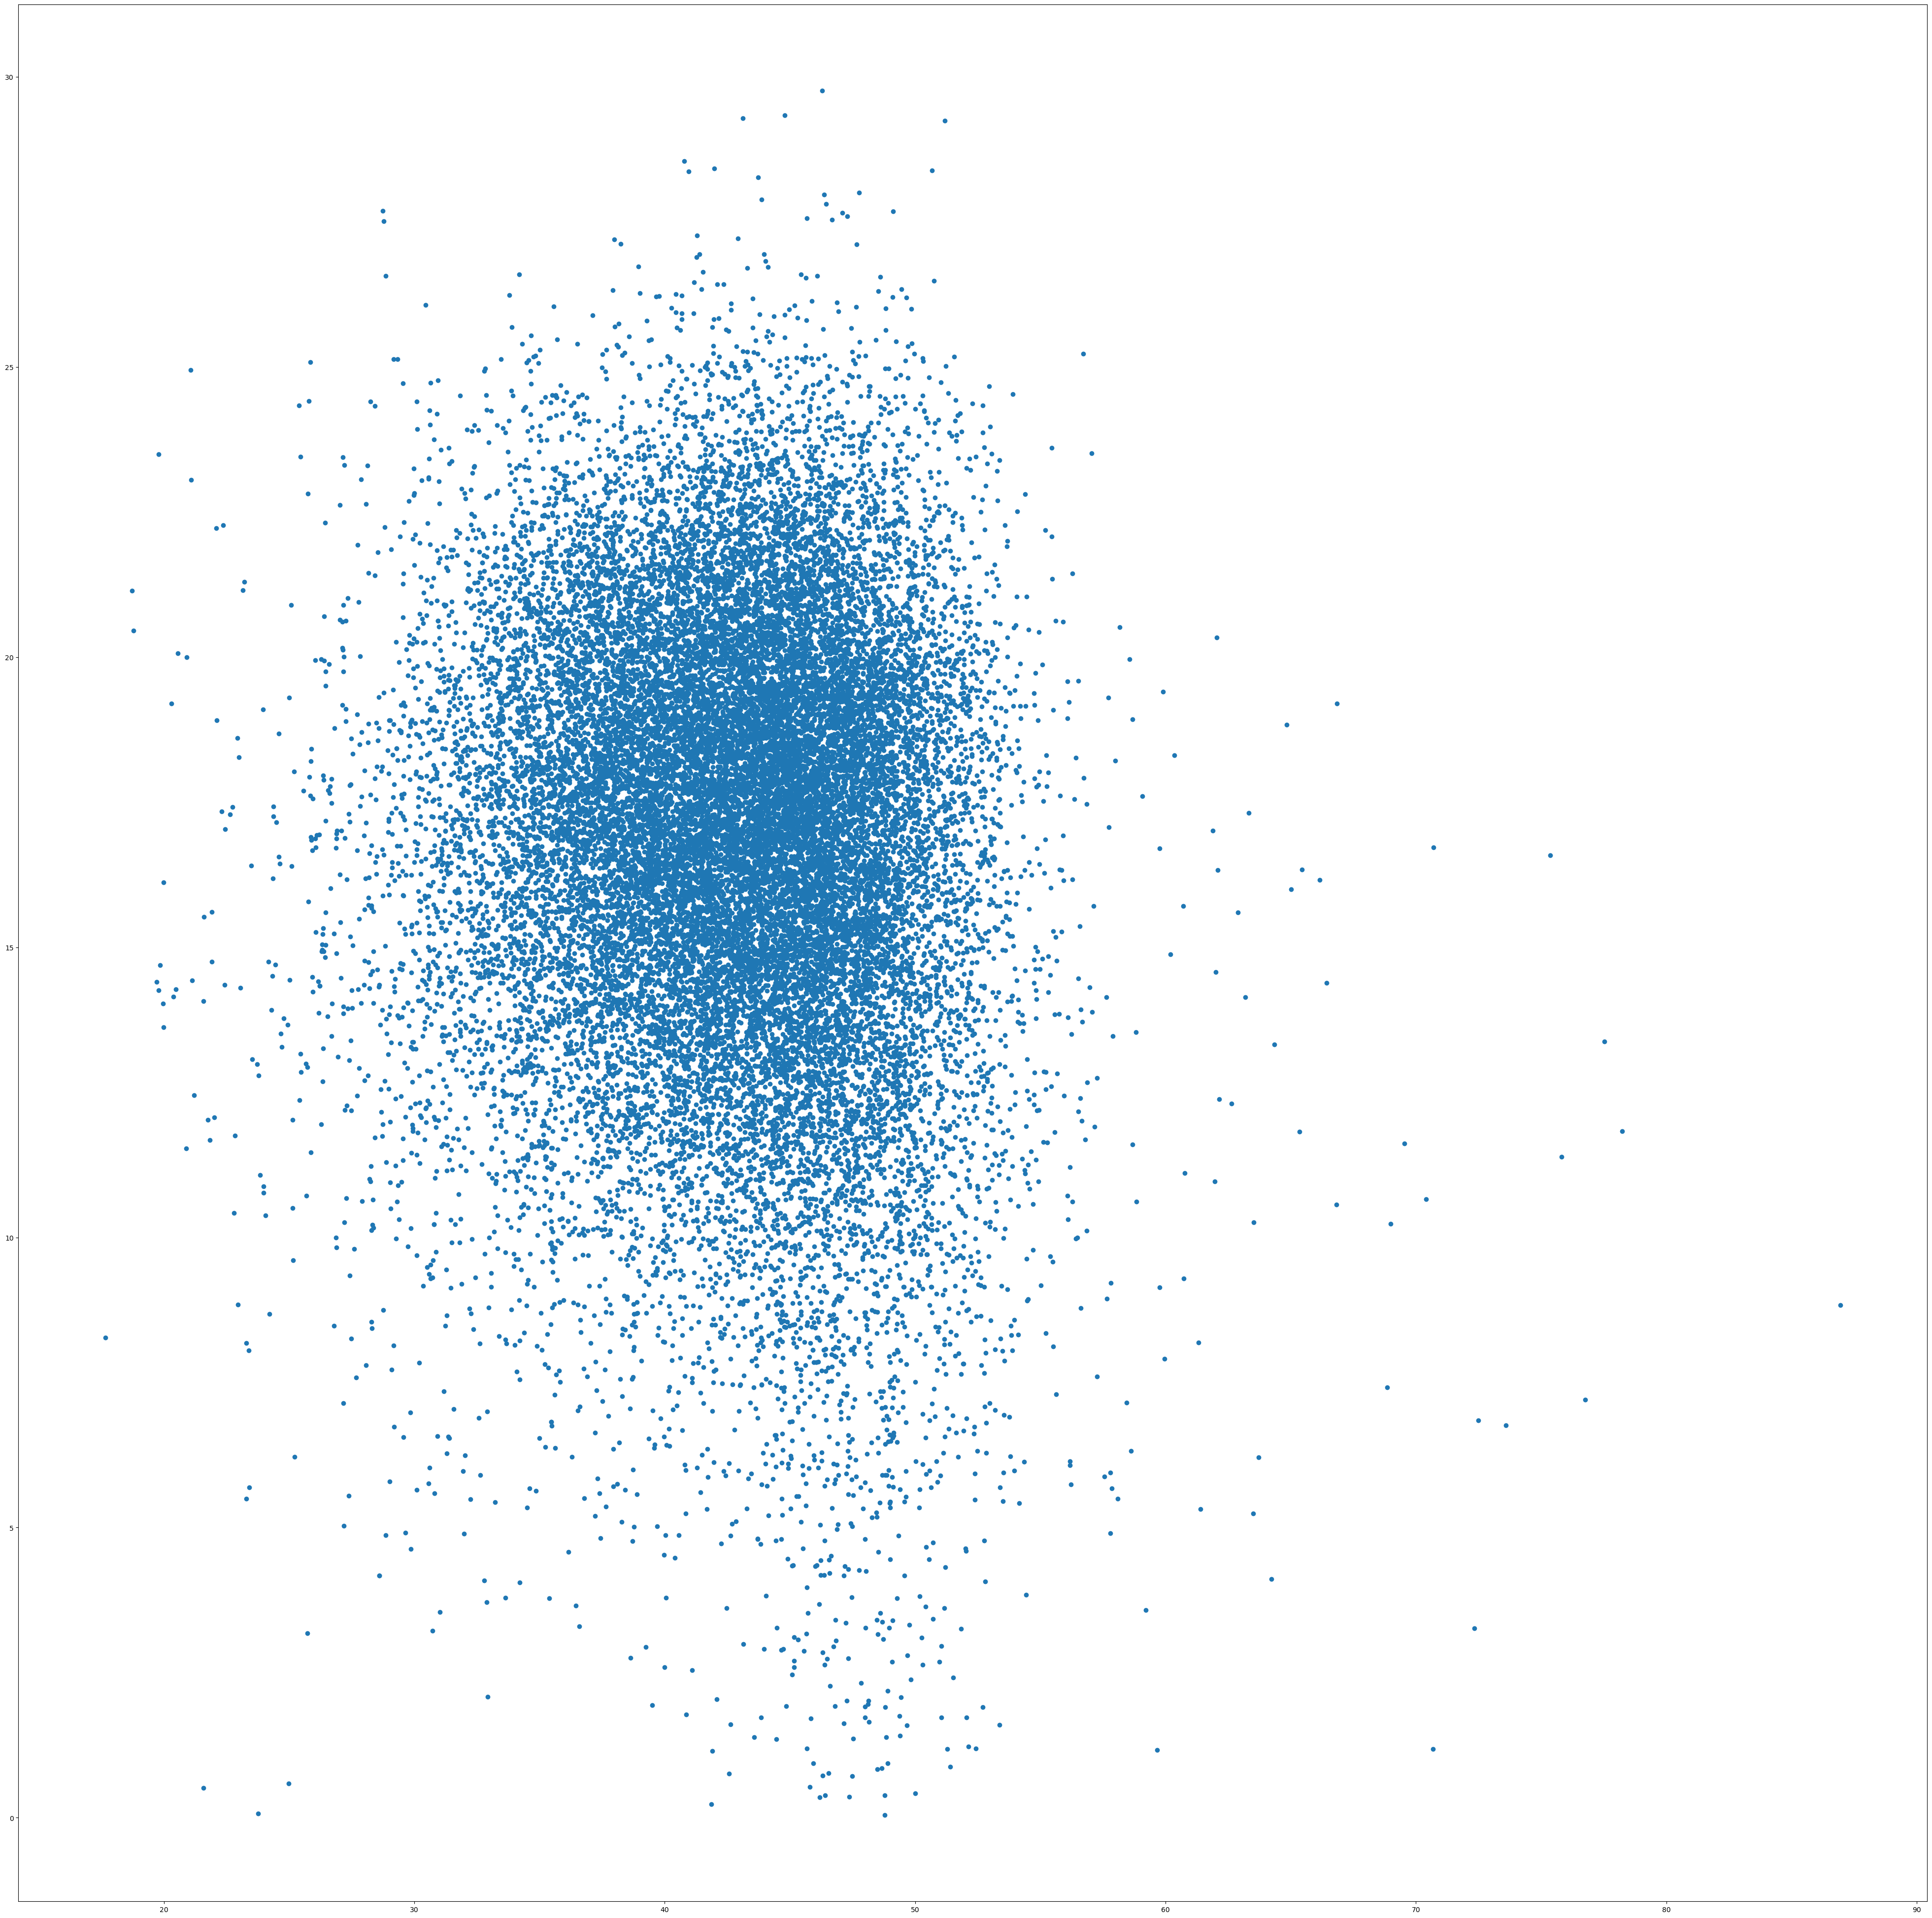

In [187]:
plt.scatter(cp4['tcwv'], cp4['shear'])

In [188]:
model.params

NameError: name 'model' is not defined

bigpos (array([], dtype=int64), array([], dtype=int64))


NameError: name 'dic4' is not defined

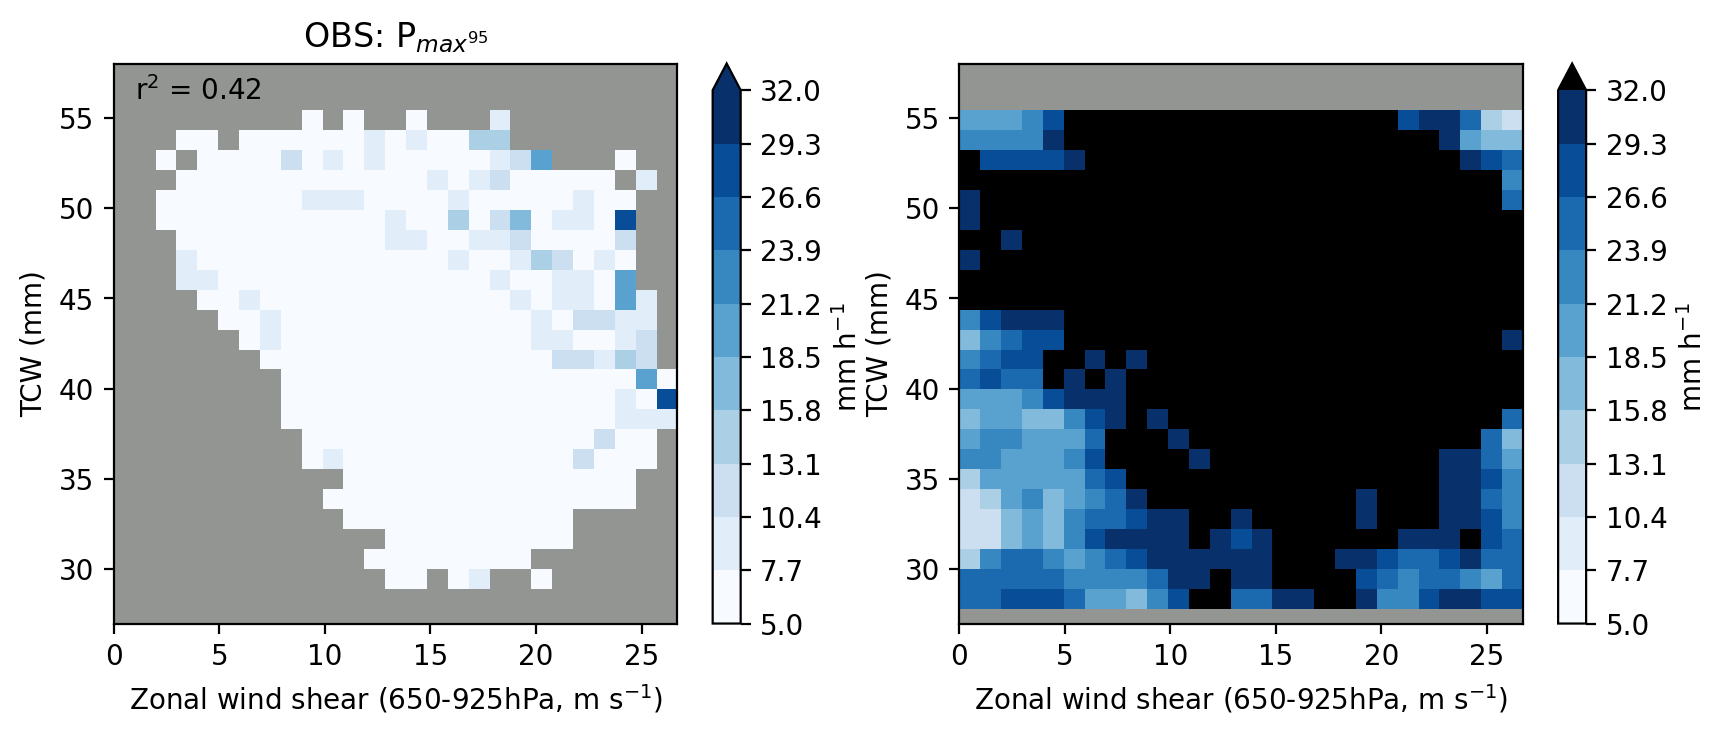

In [74]:
f = plt.figure(figsize=(10,8), dpi=200)
cmap='Blues'
vmins = 5
vmaxs = 32
pixelval = 10
cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
ax = f.add_subplot(2,2,1)
ax.set_facecolor('xkcd:grey')
dd = thresh.statistic.T
invalid = count.statistic.T < pixelval
dd[invalid] = np.nan


dd = dd/count.statistic.T*100
#dd = gauss(dd, 0.5)

bigpos = np.where(dd>60)
print('bigpos', bigpos)
mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
#plt.plot(testbins[0][bigpos[1]+1],testbins[1][bigpos[0]+1], 'o', color='grey', ms=1)
ax.set_ylim(27,58)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('TCW (mm)')
plt.text(1,56, r'r$^2$ = '+str(np.round(dicobs['model'].rsquared,2)), fontsize=10)
plt.title('OBS: P$_{max^{95}}$')

cbar = plt.colorbar(mp, ticks=np.linspace(vmins, vmaxs,11), extend='max')
cbar.set_label('mm h$^{-1}$')

ax = f.add_subplot(2,2,2)
ax.set_facecolor('xkcd:grey')
dd = gauss(ret4.statistic.T, 0.7)
invalid = count4.statistic.T < pixelval
dd[invalid] = np.nan
cmapp.set_over("black")
mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
cbar = plt.colorbar(mp, ticks=np.linspace(vmins,vmaxs,11), extend='max')
cbar.set_label('mm h$^{-1}$')
ax.set_ylim(27,58)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('TCW (mm)')
plt.text(1,56, r'r$^2$ = '+str(np.round(dic4['model'].rsquared,2)), fontsize=10)
plt.title('CP4$_H$: P$_{max^{95}}$')

ax2 = f.add_subplot(223)
plt.plot(tdicobs['bins'],tdicobs['valid'], '-ko', label=r'OBS | $\dfrac{\partial P_{max^{95}}}{\partial TCW}$: ' + str(np.round(tdicobs['slope'],2))+r'$\pm$'+str(np.round(dicobs['model'].bse[2],2)))
# plt.fill_between(tdicobs['bins'],tdicobs['p10'],tdicobs['p90'], color='k', alpha=0.15)
# plt.fill_between(tdic4['bins'],tdic4['p10'],tdic4['p90'], color='xkcd:blue', alpha=0.15)
plt.plot(tdic4['bins'],tdic4['valid'], color='xkcd:blue', marker='o', label='CP4$_H$ | $\dfrac{\partial P_{max^{95}}}{\partial TCW}$: ' + str(np.round(tdic4['slope'],2))+'$\pm$'+str(np.round(dic4['model'].bse[2],2)))


#plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
#plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(tdicobs['bins'],(tdicobs['slope']-np.array(dicobs['model'].bse[2]))*tdicobs['bins']+tdicobs['intercept']-dicobs['model'].bse[0], linestyle='dashed', color='k', linewidth=0.5, alpha=0.15)
# plt.plot(tdicobs['bins'],(tdicobs['slope']+np.array(dicobs['model'].bse[2]))*tdicobs['bins']+tdicobs['intercept']+dicobs['model'].bse[0], linestyle='dashed', color='k', linewidth=0.5, alpha=0.15)

#plt.fill_between(tdic4['bins'],tdic4['p10'],tdic4['p90'], color='xkcd:blue', alpha=0.15)


#plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept'], linestyle='dashed', color='k', linewidth=0.5)

# plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept']+tdicobs['std_est']*2, linestyle='dotted', color='grey', linewidth=0.5)
# plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept']-tdicobs['std_est']*2, linestyle='dotted', color='grey', linewidth=0.5)

# plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept']+tdic4['std_est']*2, linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept']-tdic4['std_est']*2, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('TCW (mm)')
plt.ylabel('$P_{max^{95}}$ (mm h$^{-1}$)')


#plt.title('Zonal wind shear')
#plt.ylim(12,31)
#plt.ylim(15,33)
#plt.ylim(25,70)
ax2.xaxis.set_minor_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(MultipleLocator(5))
plt.legend(loc='upper left')
# plt.text(50,28, r'SE$_{OBS} = $'+str(np.round(tdicobs['std_est'],2)), fontsize=10)
# plt.text(50,26, r'SE$_{CP4_H} = $'+str(np.round(tdic4['std_est'],2)), fontsize=10)




ax3 = f.add_subplot(224)
plt.plot(sdicobs['bins'],sdicobs['valid'], '-ko', label=r'OBS | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial shear}$: ' + str(np.round(sdicobs['slope'],2))+'$\pm$'+str(np.round(dicobs['model'].bse[1],2)))
# plt.fill_between(sdicobs['bins'],sdicobs['p10'],sdicobs['p90'], color='k', alpha=0.15)
# plt.fill_between(sdic4['bins'],sdic4['p10'],sdic4['p90'], color='xkcd:blue', alpha=0.15)

plt.plot(sdic4['bins'],sdic4['valid'], color='xkcd:blue', marker='o', label=r'CP4$_{H}$ | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial shear}$: ' + str(np.round(sdic4['slope'],2))+'$\pm$'+str(np.round(dic4['model'].bse[1],2)))
#plt.plot(sdicobs['bins'],sdicobs['slope']*sdicobs['bins']+sdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
#plt.plot(sdicobs['bins'],sdicobs['slope']*sdicobs['bins']+sdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)


#plt.plot(sdic4['bins'],sdic4['slope']*sdic4['bins']+sdic4['intercept'], linestyle='dashed', color='k', linewidth=0.5)

fdic = {'obs_shear' : sdicobs['slope'], 'cp4_shear' : sdic4['slope']}
import pickle
pickle.dump(fdic, open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors_small.p', "wb"))

#plt.xlabel('Specific humidity (925hPa, g kg$^{-1}$)')

plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('$P_{max^{95}}$ (mm h$^{-1}$)')
#plt.title('Total column water vapour')
plt.legend(loc='upper left')
# plt.text(21,28, r'SE$_{OBS} = $'+str(np.round(dicobs['model'].bse[0],2)), fontsize=10)
# plt.text(21,26, r'SE$_{CP4_H} = $'+str(np.round(sdic4['std_est'],2)), fontsize=10)
plt.tight_layout()
#plt.ylim(25,70)
ax3.xaxis.set_minor_locator(MultipleLocator(5))
ax3.yaxis.set_minor_locator(MultipleLocator(5))


text = ['a', 'b', 'c', 'd']
plt.annotate(text[0], xy=(0.01, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.53, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.01, 0.49), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.53, 0.49), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)


#plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_'+tag+'_15km_'+ttag+'_NOFUTURE_50Cp90_duo_gauss_hourly2_8mm_new.jpg')

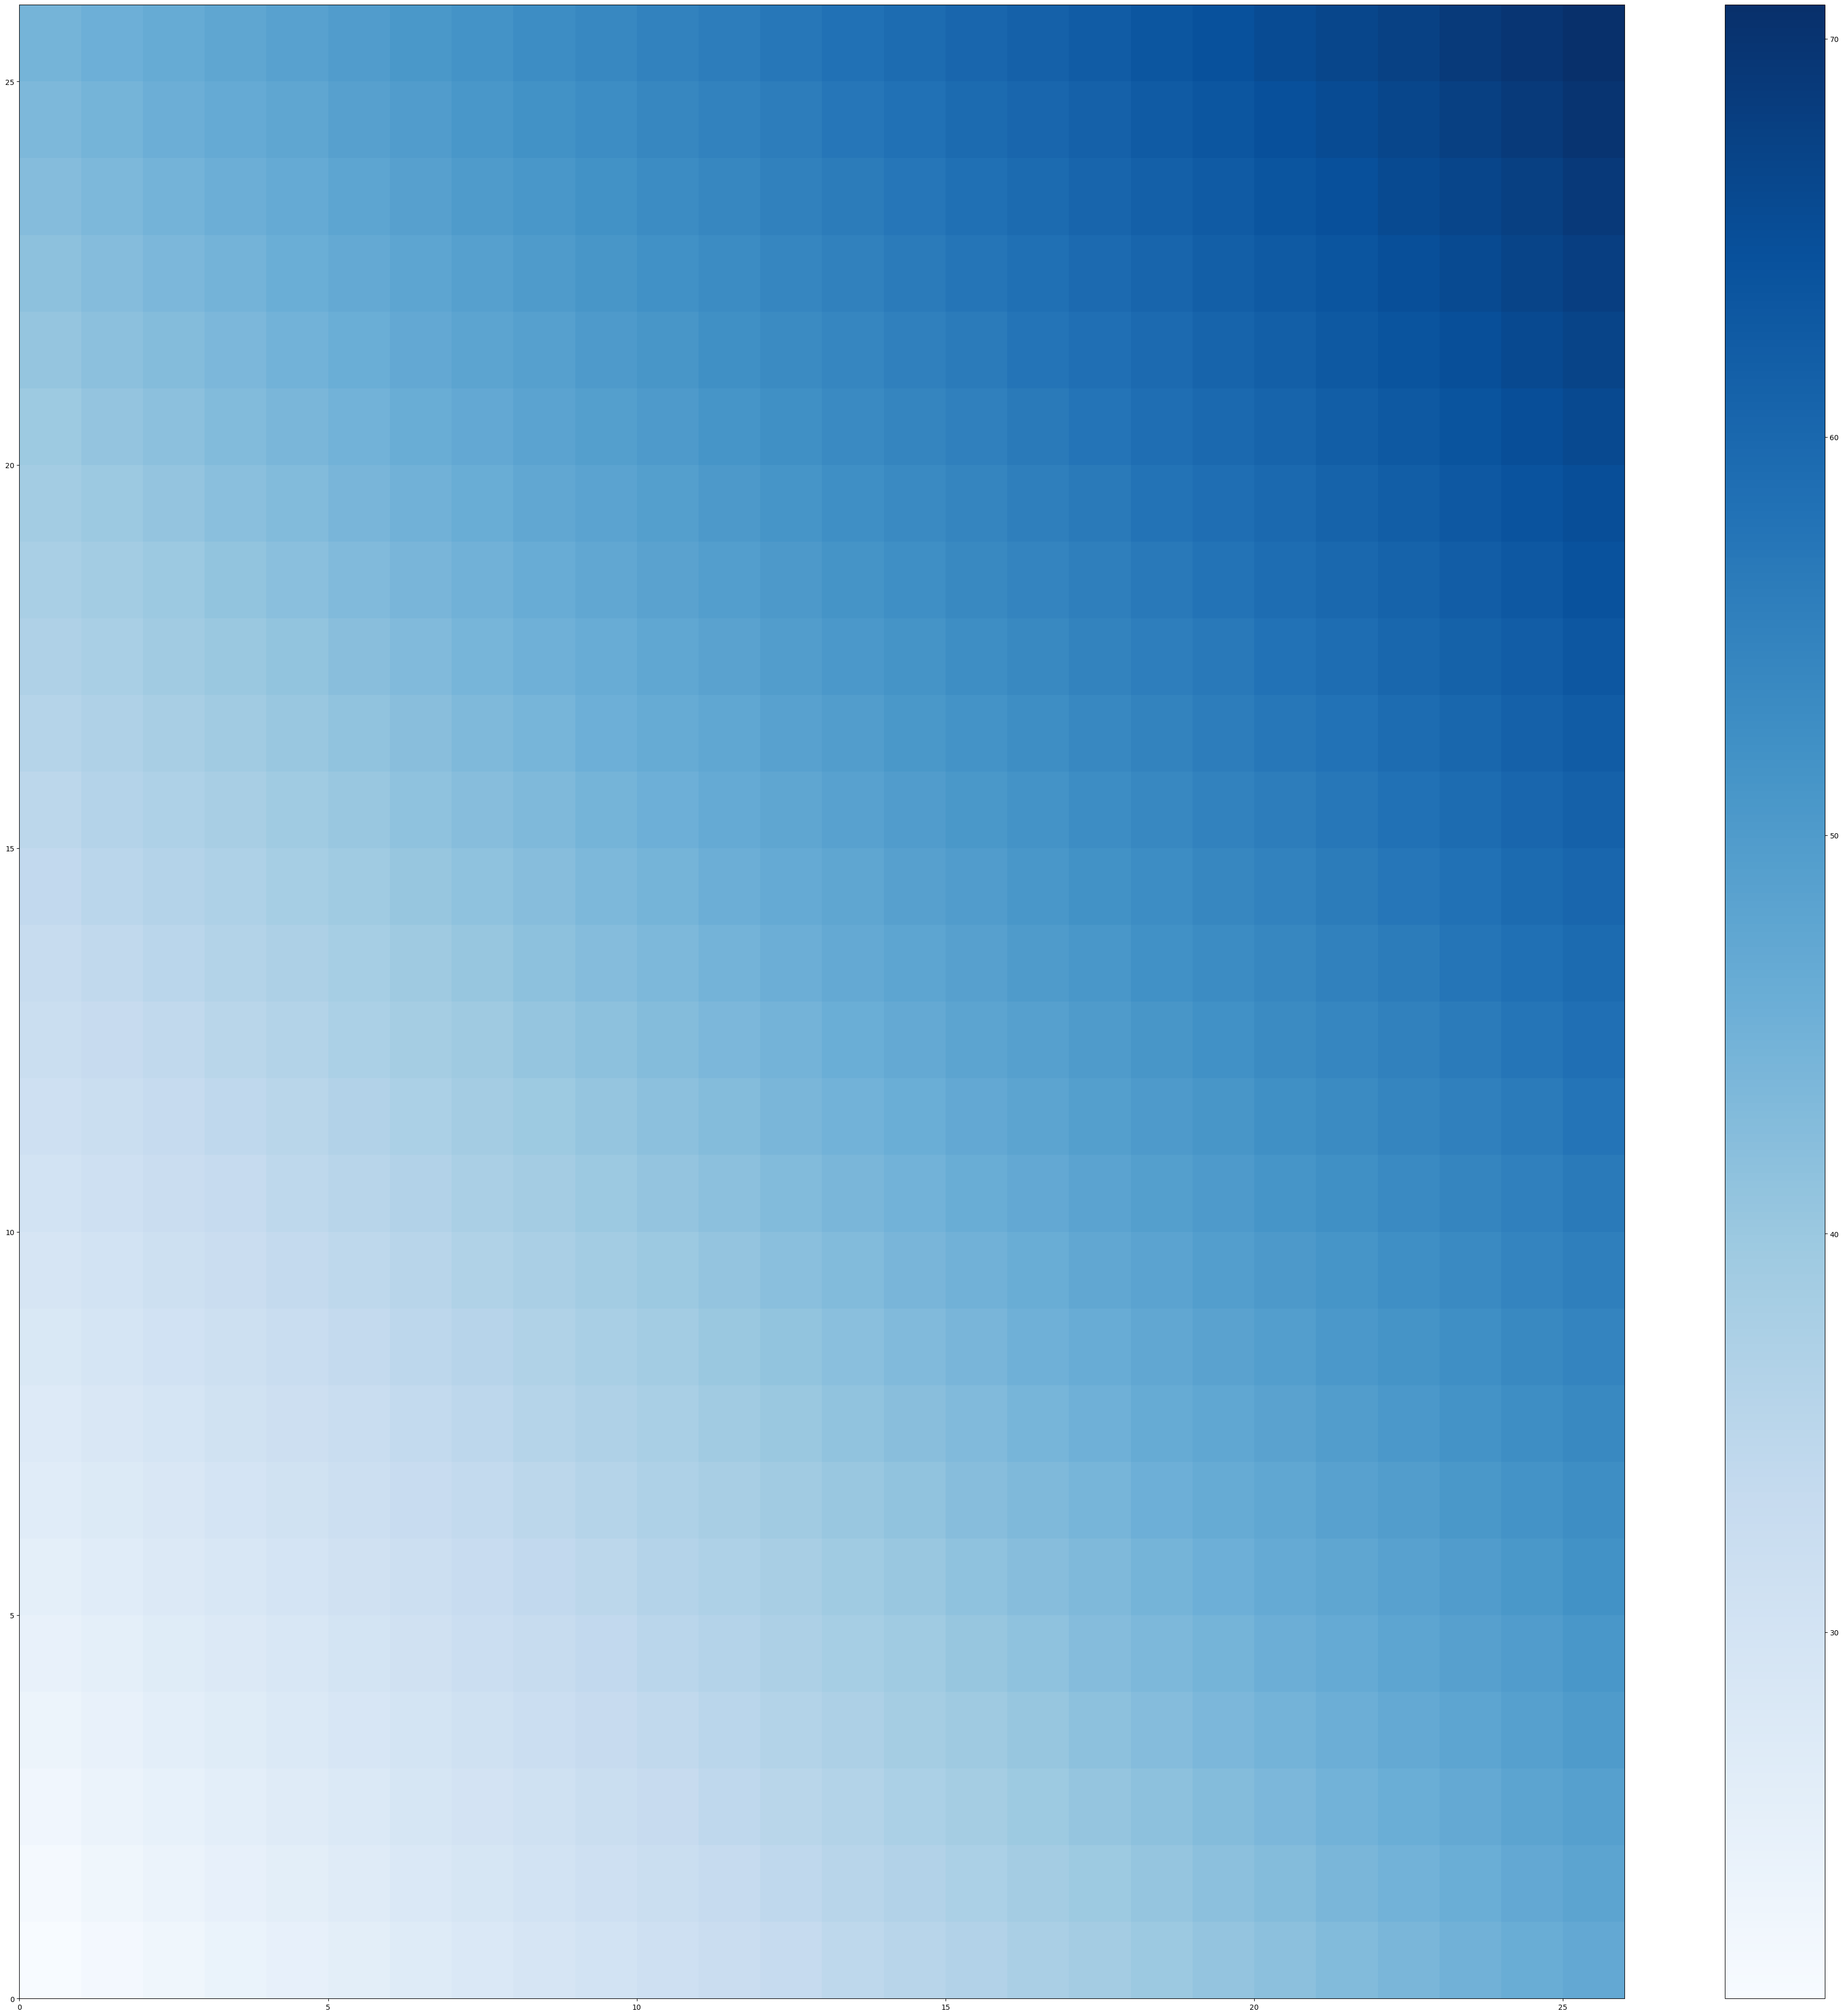

In [189]:
plt.pcolormesh(tests, cmap='Blues')
plt.colorbar()